# <center> <strong> Определение уязвимых групп населения </strong> </center> 

## <strong> 1. Постановка задачи </strong> 


* Кластеризовать регионы России и определить, какие из них наиболее
остро нуждаются в помощи малообеспеченным/неблагополучным
слоям населения;
* Описать группы населения, сталкивающиеся с бедностью;
* Определить:
    1. Влияет ли число детей, пенсионеров и других социально уязвимых
групп на уровень бедности в регионе;
    2. Связаны ли уровень бедности/социального неблагополучия с
производством и потреблением в регионе;
    3. Какие ещё зависимости можно наблюдать

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import requests


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.float_format", "{:.2f}".format)

plt.style.use('seaborn')

##### В условии предоставлено большое количество таблиц, которые необходимо преобразовать и объединить в один датасет, на основе которого будем разделять регионы по кластерам. 

##### Приведём все таблицы к формату, позволяющему объединять их друг с другом по признаку названия региона. 

In [2]:
df_child_mort_rural = pd.read_excel('data/child_mortality_rural_1990_2021.xls', header=2)

df_child_mort_rural.drop(['Unnamed: 1', 'Unnamed: 2'], axis=1, inplace=True)
df_child_mort_rural.rename(columns = {'Unnamed: 0':'region'}, inplace=True)
df_child_mort_rural['region'] = df_child_mort_rural['region'].apply(lambda arg: ' '.join(arg.split()))
    
df_child_mort_rural.drop_duplicates(subset = 'region', inplace=True)

df_child_mort_rural.set_index('region', inplace=True)
row_to_remove = ['Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)', 'Агинский Бурятский округ (Забайкальский край)', 'Эвенкийский автономный округ (Красноярский край)', 'Коми-Пермяцкий округ, входящий в состав Пермского края', 'Корякский округ, входящий в состав Камчатского края', 'Усть-Ордынский Бурятский округ', 'Архангельская область', 'Тюменская область']
df_child_mort_rural.drop(row_to_remove, axis=0, inplace=True)

df_child_mort_rural.reset_index(inplace=True)

Избавимся от информации об федеральных округах и государства в целом. Оставим информацию только об областях. Так же добавим новый признак с средним показателем начиная с 14 года. Т.е. возьмём наиболее актуальную информацию.

In [3]:
drop_list = ['федеральный', 'российская']
df_child_mort_rural.set_index('region', inplace=True)

for region in df_child_mort_rural.index:
    for name in drop_list:
        if name in region.lower():
            print(f'Remove region: {region}')
            df_child_mort_rural.drop(region, axis=0, inplace=True)
            
df_child_mort_rural.reset_index(inplace=True)


for col in df_child_mort_rural.columns: # Заменим нули в данных на 'NaN'
    df_child_mort_rural[col] = df_child_mort_rural[col].apply(lambda x: float('nan') if x == 0 else x)

df_child_mort_rural['ch_mort_rural'] = [df_child_mort_rural.iloc[i, 14:].mean() for i in range(df_child_mort_rural.shape[0])] 

Remove region: Российская Федерация
Remove region: Центральный федеральный округ
Remove region: Северо-Западный федеральный округ
Remove region: Южный федеральный округ (по 2009 год)
Remove region: Южный федеральный округ (с 2010 года)
Remove region: Южный федеральный округ (с 29.07.2016)
Remove region: Северо-Кавказский федеральный округ
Remove region: Приволжский федеральный округ
Remove region: Уральский федеральный округ
Remove region: Сибирский федеральный округ
Remove region: Дальневосточный федеральный округ
Remove region: Крымский федеральный округ


При помощи линейной диаграммы визуализируем новый признак. 

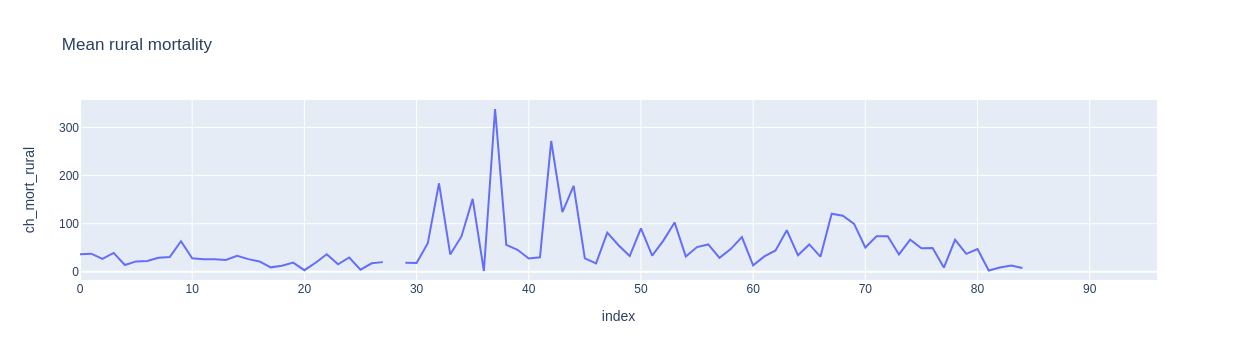

In [4]:
fig = px.line(df_child_mort_rural, y='ch_mort_rural', width = 900, title = 'Mean rural mortality')
fig.show()

Видим, что отсутствуют данные с 85 по 96 индексы. Избавимся от этих объектов и отфильтруем датасет, оставив только признак со среднем значением по годам. 

In [4]:
print(df_child_mort_rural.shape)
df_child_mort_rural = df_child_mort_rural.loc[:, ['region', 'ch_mort_rural']]
df_child_mort_rural = df_child_mort_rural.iloc[:85]
print(df_child_mort_rural.shape)
df_child_mort_rural

(97, 34)
(85, 2)


region  ch_mort_rural
0           Белгородская область          36.53
1               Брянская область          37.53
2           Владимирская область          26.68
3            Воронежская область          39.11
4             Ивановская область          14.00
..                           ...            ...
80              Амурская область          47.21
81           Магаданская область           2.43
82           Сахалинская область           8.95
83  Еврейская автономная область          12.95
84    Чукотский автономный округ           7.58

[85 rows x 2 columns]

Сравним фактические существующие на данные момент регионы России с регионами полученными в резульатте обработки датасета. Убедимся в том, что мы ничего не потеряли и у на нет ничего лишнего. Для этого воспользуемся воспользуемся информацией с Википедии. 

In [6]:
url = 'https://ru.wikipedia.org/wiki/%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BE%D0%BA%D1%80%D1%83%D0%B3%D0%B0_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8'

req = requests.get(url)

soup = BeautifulSoup(req.text)
info = soup.find('div', class_='mw-parser-output')

table = info.find_all('table')
table = table[2]

In [7]:
region_names = table.find_all('div', class_='hatnote navigation-not-searchable')
region_names = [x.text for x in region_names]
region_names = [re.sub(r'Основная статья: ', '', x) for x in region_names]

region_names

['Центральный федеральный округ',
 'Северо-Западный федеральный округ',
 'Южный федеральный округ',
 'Северо-Кавказский федеральный округ',
 'Приволжский федеральный округ',
 'Уральский федеральный округ',
 'Сибирский федеральный округ',
 'Дальневосточный федеральный округ']

In [10]:
states = table.find_all('ul')
reg_dict = {}
reg_ls = []

for i, val in enumerate(region_names):
    reg_ls.append(states[i].text)

for i, val in enumerate(reg_ls):
    regs = re.sub('\n', ',', val)
    regs = regs.split(',')
    reg_ls[i] = regs
    reg_ls = [[' '.join(j.rsplit()) for j in i] for i in reg_ls]

for i, group in enumerate(reg_ls):
    for reg in group:
        reg_dict[reg] = region_names[i]
        
reg_dict
reg_list = [reg for reg in reg_dict.keys()]

Итак, мы получили актуальынй список названий регионов. Теперь сравним сравнение двух множеств: имён регионов, которые мы получили из Википедии и имён регионов, которые у нас оразовались в результате обработки датасета.

In [11]:
print(len(set(reg_lsit).difference(df_child_mort_rural['region'].values)))
print(len(set(df_child_mort_rural['region'].values).difference(reg_lsit)))
print(set(reg_lsit).difference(df_child_mort_rural['region'].values))
print(set(df_child_mort_rural['region'].values).difference(reg_lsit))

14
14
{'Город федерального значения Санкт-Петербург', 'Кемеровская область — Кузбасс', 'Ямало-Ненецкий автономный округ', 'Республика Адыгея', 'Город федерального значения Москва', 'Архангельская область', 'Республика Татарстан', 'Тюменская область', 'Ненецкий автономный округ', 'Республика Крым[13]', 'Республика Северная Осетия — Алания', 'Город федерального значения Севастополь[13]', 'Ханты-Мансийский автономный округ — Югра', 'Чувашская Республика'}
{'Чувашская Республика - Чувашия', 'Кемеровская область - Кузбасс', 'Ненецкий автономный округ (Архангельская область)', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Республика Татарстан (Татарстан)', 'Архангельская область (кроме Ненецкого автономного округа)', 'Ямало-Ненецкий автономный округ (Тюменская область)', 'Ханты-Мансийский автономный округ - Югра (Тюменская область)', 'Город федерального значения Севастополь', 'Город Москва столица Российской Федерации город федер

Списки по количеству регионов полностью совпадают. При этом 14 названий хоть и имеют различия в написании, но относятся к одному региону. 

Дальше продолжаем рабоатть с полученным датасетом как с базовым. Последующие датасеты будет приводить к формату первого. Так же написания регионов будет приводить в соотвествие с написанием в базовом датасете.

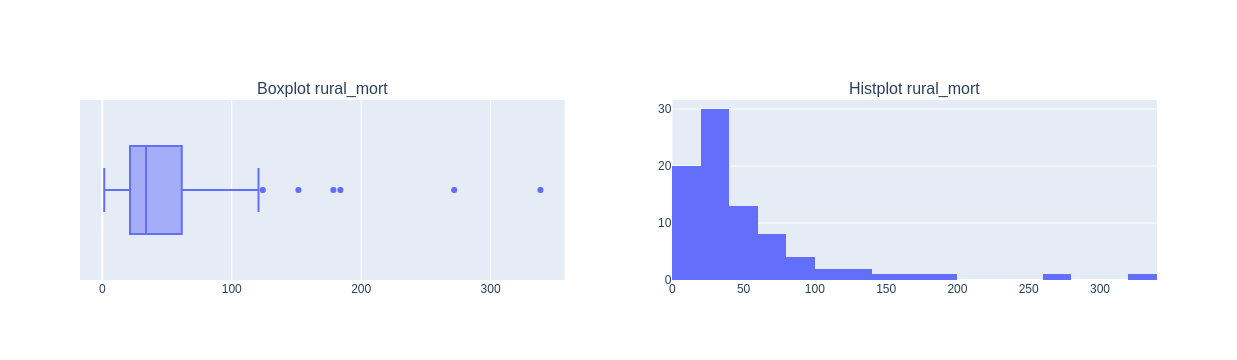

In [27]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows = 1, cols = 2,
    column_widths=[100, 100],
    subplot_titles=(
        'Boxplot rural_mort', 'Histplot rural_mort'
    )
)

fig.add_trace(px.box(df_child_mort_rural, x='ch_mort_rural')['data'][0], row=1, col=1)
fig.add_trace(px.histogram(df_child_mort_rural, x='ch_mort_rural', nbins = 25)['data'][0], row=1, col=2)

fig.show()

1. Переходим к обработке следующего документа формата эксель. Документ включает в себя 4 листа. 
2. Создадим отдельный датасет для каждого листа и в каждом датасете создадим признак со средним значением по всем годам. После этого оставим в датасетах только вновьобразованные признаки.  
3. Объединим все датасеты в один.

In [5]:
sheets_name = ['per_capita_cash_income', 'real_incomes', 'formal_wage_paid', 'real_pay']

df_1 = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=sheets_name[0], index_col='region')
df_2 = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=sheets_name[1], index_col='region')
df_3 = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=sheets_name[2], index_col='region')
df_4 = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=sheets_name[3], index_col='region')

df_4[2015.0] = df_4[2015.0].apply(lambda arg: re.sub(r'\)', '', arg) if type(arg) == str else arg)
df_4[2015.0] = df_4[2015.0].apply(lambda arg: re.sub(r'\,', '.', arg) if type(arg) == str else arg)
df_4[2015.0] = df_4[2015.0].apply(lambda arg: np.nan if arg == '…' else arg)
df_4[2015.0] = df_4[2015.0].astype('float64')

df_1[f'{sheets_name[0]}'] = [df_1.iloc[i].mean() for i in range(df_1.shape[0])]
df_2[f'{sheets_name[1]}'] = [df_2.iloc[i].mean() for i in range(df_2.shape[0])]
df_3[f'{sheets_name[2]}'] = [df_3.iloc[i].mean() for i in range(df_3.shape[0])]
df_4[f'{sheets_name[3]}'] = [df_4.iloc[i].mean() for i in range(df_4.shape[0])]

df_1 = df_1[f'{sheets_name[0]}'].reset_index()
df_2 = df_2[f'{sheets_name[1]}'].reset_index().drop('region', axis=1)
df_3 = df_3[f'{sheets_name[2]}'].reset_index().drop('region', axis=1)
df_4 = df_4[f'{sheets_name[3]}'].reset_index().drop('region', axis=1)

df_cash_income = pd.concat([df_1, df_2, df_3, df_4], axis=1)
df_cash_income.dropna(inplace=True)
df_cash_income['region'] = df_cash_income['region'].apply(lambda arg: ' '.join(arg.split()))

Выведим на экран два множества:
1. Уникальные названия базавого датасета, к которому будем присоединять все остальные обработанные датасеты. 
2. Уникальыне названия нового датасета. 

Эта даст нам инфомрацию о различиях в названиях регионов. Таким образом мы сможем в новом датасете исправить имена регионов и затем по ним объединить оба датасета. 

In [6]:
print(set(df_child_mort_rural['region'].values).difference(df_cash_income['region'].values))
print(set(df_cash_income['region'].values).difference(df_child_mort_rural['region'].values))

{'Ненецкий автономный округ (Архангельская область)', 'Город федерального значения Севастополь', 'Республика Адыгея (Адыгея)', 'Архангельская область (кроме Ненецкого автономного округа)', 'Город Москва столица Российской Федерации город федерального значения', 'Город Санкт-Петербург город федерального значения', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Чувашская Республика - Чувашия', 'Ямало-Ненецкий автономный округ (Тюменская область)', 'Кемеровская область - Кузбасс', 'Республика Татарстан (Татарстан)', 'Ханты-Мансийский автономный округ - Югра (Тюменская область)'}
{'Кемеровская область', 'Северо-Кавказский федеральный округ', 'Архангельская область без автономного округа', 'Южный федеральный округ', 'Приволжский федеральный округ', 'Чувашская Республика', 'Тюменская область без автономных округов', 'Центральный федеральный округ', 'Северо-Западный федеральный округ', 'г. Москва', 'Ямало-Ненецкий автономный округ'

In [6]:
df_cash_income.loc[df_cash_income['region'] == 'г. Санкт-Петербург', 'region'] = 'Город Санкт-Петербург город федерального значения'
df_cash_income.loc[df_cash_income['region'] == 'г. Севастополь', 'region'] = 'Город федерального значения Севастополь'
df_cash_income.loc[df_cash_income['region'] == 'г. Москва', 'region'] = 'Город Москва столица Российской Федерации город федерального значения'
df_cash_income.loc[df_cash_income['region'] == 'Республика Адыгея', 'region'] = 'Республика Адыгея (Адыгея)'
df_cash_income.loc[df_cash_income['region'] == 'Чувашская Республика', 'region'] = 'Чувашская Республика - Чувашия'
df_cash_income.loc[df_cash_income['region'] == 'Кемеровская область', 'region'] = 'Кемеровская область - Кузбасс'
df_cash_income.loc[df_cash_income['region'] == 'Архангельская область без автономного округа', 'region'] = 'Архангельская область (кроме Ненецкого автономного округа)'
df_cash_income.loc[df_cash_income['region'] == 'Республика Татарстан', 'region'] = 'Республика Татарстан (Татарстан)'
df_cash_income.loc[df_cash_income['region'] == 'Ямало-Ненецкий автономный округ', 'region'] = 'Ямало-Ненецкий автономный округ (Тюменская область)'
df_cash_income.loc[df_cash_income['region'] == 'Ненецкий автономный округ', 'region'] = 'Ненецкий автономный округ (Архангельская область)'
df_cash_income.loc[df_cash_income['region'] == 'Ханты-Мансийский автономный округ - Югра', 'region'] = 'Ханты-Мансийский автономный округ - Югра (Тюменская область)'
df_cash_income.loc[df_cash_income['region'] == 'Тюменская область без автономных округов', 'region'] = 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'

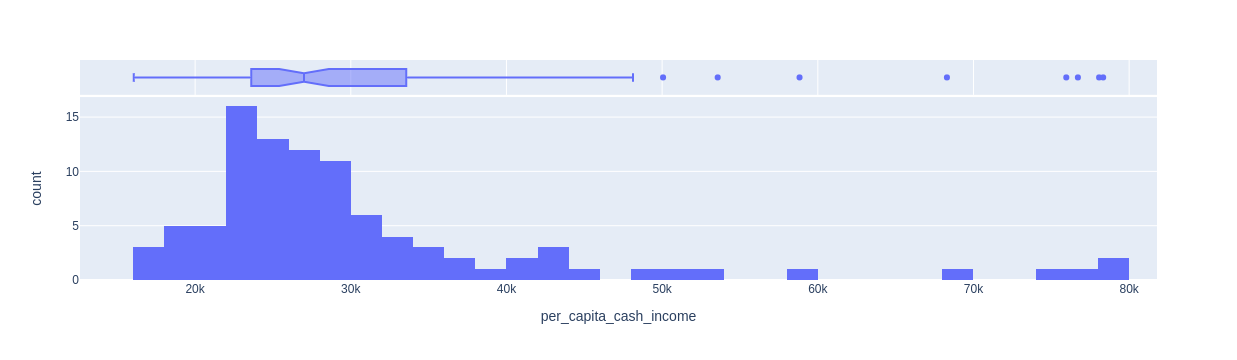

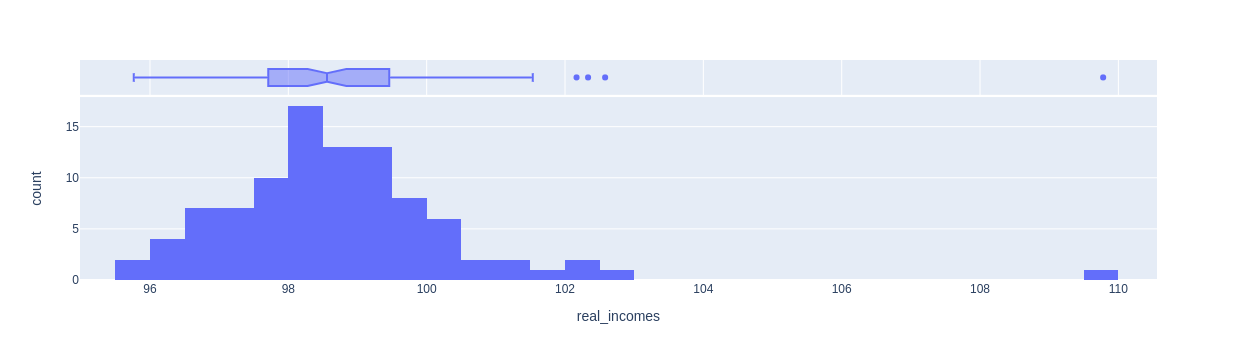

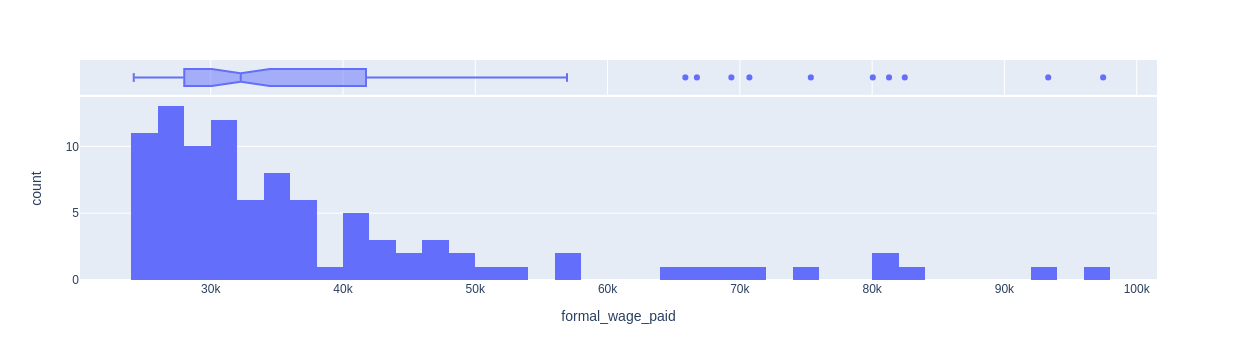

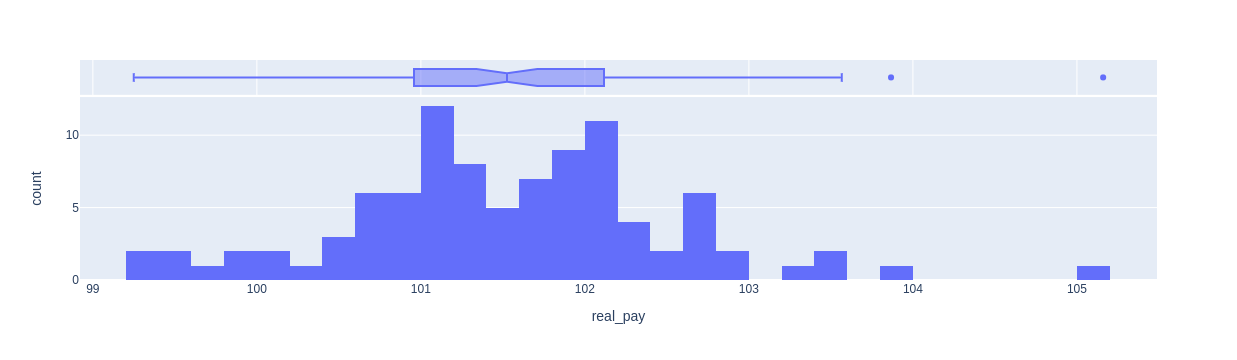

In [51]:
df_cash_income

for i, col in enumerate(df_cash_income.columns[1:]):
    fig = px.histogram(df_cash_income, x = col, nbins = 50, marginal='box', width = 600)
    fig.show()

Имена регионов приведены к единому формату. Теперь можем объединять датасеты.

In [7]:
merged_df = df_child_mort_rural.merge(df_cash_income, how = 'left', on='region')
merged_df.shape

(85, 6)

Аналогичные манипуляции проводим с последующими таблицами. 

In [8]:
df_child_mort_urban = pd.read_excel('data/child_mortality_urban_1990_2021.xls', header=2)

df_child_mort_urban.drop(['Unnamed: 1', 'Unnamed: 2'], axis=1, inplace=True)

df_child_mort_urban.rename(columns = {'Unnamed: 0':'region'}, inplace=True)
df_child_mort_urban['region'] = df_child_mort_urban['region'].apply(lambda arg: ' '.join(arg.split()))

df_child_mort_urban

region     1990     1991     1992     1993  \
0             Российская Федерация 23902.00 21549.00 19097.00 18106.00   
1    Центральный федеральный округ  5317.00  4734.00  4175.00  3899.00   
2             Белгородская область   209.00   198.00   165.00   165.00   
3                 Брянская область   198.00   195.00   200.00   176.00   
4             Владимирская область   221.00   209.00   179.00   148.00   
..                             ...      ...      ...      ...      ...   
114        Северо-Кавказский район  2591.00  2594.00  2433.00  2112.00   
115                Уральский район  3402.00  3044.00  2707.00  2626.00   
116        Западно-Сибирский район  2645.00  2404.00  2132.00  2095.00   
117       Восточно-Сибирский район  1898.00  1794.00  1498.00  1518.00   
118          Дальневосточный район  1600.00  1400.00  1246.00  1115.00   

        1994     1995     1996     1997     1998  ...     2012     2013  \
0   17131.00 16258.00 14842.00 14034.00 13883.00  ... 10843.00 10418.00   
1    3871.00  3631.00  3254.00      NaN      NaN  ...  2789.00  2735.00   
2     153.00   131.00   102.00   100.00    99.00  ...    84.00    68.00   
3     157.00   125.00   116.00   135.00   107.00  ...    81.00    77.00   
4     165.00   146.00   114.00   123.00   130.00  ...    97.00    86.00   
..       ...      ...      ...      ...      ...  ...      ...      ...   
114      NaN      NaN      NaN  1593.00  1718.00  ...      NaN      NaN   
115      NaN      NaN      NaN  2054.00  2073.00  ...      NaN      NaN   
116      NaN      NaN      NaN  1491.00  1394.00  ...      NaN      NaN   
117      NaN      NaN      NaN  1180.00  1182.00  ...      NaN      NaN   
118      NaN      NaN      NaN   887.00   923.00  ...      NaN      NaN   

       2014    2015    2016    2017    2018    2019    2020    2021  
0   9641.00 8499.00 7860.00 6545.00 5723.00 5206.00 4573.00 4664.00  
1   2402.00 2228.00 2146.00 1785.00 1593.00 1409.00 1153.00 1192.00  
2     62.00   68.00   72.00   43.00   40.00   23.00   25.00   34.00  
3     87.00   67.00   67.00   65.00   33.00   26.00   29.00   14.00  
4     87.00   76.00   72.00   59.00   45.00   43.00   51.00   52.00  
..      ...     ...     ...     ...     ...     ...     ...     ...  
114     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
115     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
116     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
117     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
118     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[119 rows x 33 columns]

In [9]:
df_child_mort_urban.dropna(axis=0, thresh = df_child_mort_urban.shape[1]*0.7, inplace=True)
df_child_mort_urban['ch_mort_urban'] = [round(df_child_mort_urban.iloc[i, 1:].mean(), 2) for i in range(df_child_mort_urban.shape[0])]
df_child_mort_urban = df_child_mort_urban.loc[:, ['region', 'ch_mort_urban']]
df_child_mort_urban

region  ch_mort_urban
0             Российская Федерация       11692.47
1    Центральный федеральный округ        2737.83
2             Белгородская область          88.03
3                 Брянская область          95.94
4             Владимирская область         107.31
..                             ...            ...
101               Амурская область         104.22
102            Магаданская область          23.44
103            Сахалинская область          57.19
104   Еврейская автономная область          27.22
105     Чукотский автономный округ           8.31

[90 rows x 2 columns]

In [11]:
print(set(merged_df['region'].values).difference(df_child_mort_urban['region'].values))
print(set(df_child_mort_urban['region'].values).difference(merged_df['region'].values))

{'Республика Крым', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Город федерального значения Севастополь', 'Архангельская область (кроме Ненецкого автономного округа)'}
{'Сибирский федеральный округ', 'Уральский федеральный округ', 'Архангельская область', 'Российская Федерация', 'Приволжский федеральный округ', 'Центральный федеральный округ', 'Северо-Западный федеральный округ', 'Тюменская область', 'Дальневосточный федеральный округ'}


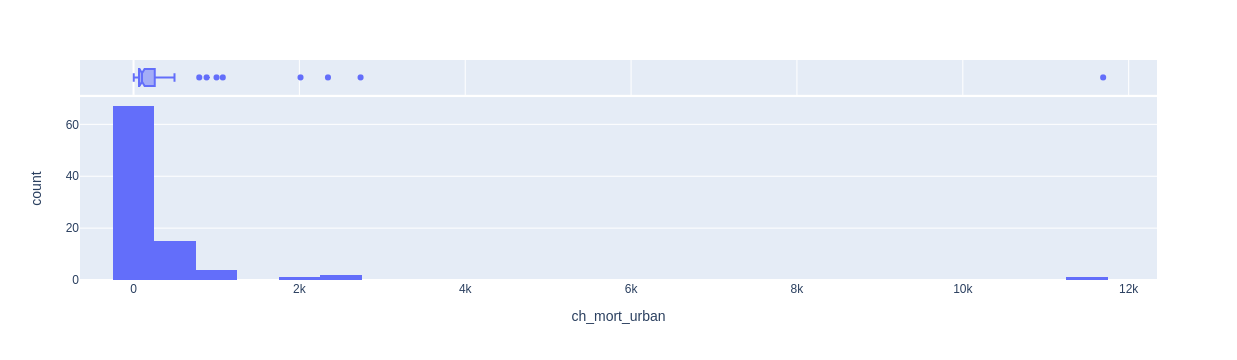

In [63]:
fig = px.histogram(df_child_mort_urban, x = 'ch_mort_urban', marginal = 'box', nbins = 25, width = 800)
fig.show()

In [10]:
merged_df = merged_df.merge(df_child_mort_urban, how='left', on='region')
merged_df.shape

(85, 7)

In [11]:
disabled = pd.read_csv('data/disabled_total_by_age_2017_2022.csv')
disabled['date'] = pd.to_datetime(disabled['date'])

last = disabled.groupby('region').mean()

last.reset_index(inplace=True)
last

region      total    18_30    31_40    41_50     51_60  \
0          Алтайский край  173039.83  7626.49 13418.02 15295.33  25707.40   
1        Амурская область   64625.03  3325.66  5248.72  6287.66  10531.98   
2   Архангельская область   84988.52  3060.48  5146.83  6899.94  12204.80   
3    Астраханская область   43462.77  2799.27  3981.23  4850.64   8200.56   
4    Белгородская область  202033.86  5353.17  9767.11 15291.14  31774.77   
..                    ...        ...      ...      ...      ...       ...   
90    Ярославская область  101446.30  2773.14  5100.50  7436.02  14258.34   
91            г. Байконур     834.06    97.21    89.09   132.67    250.53   
92           город Москва 1006747.45 29759.81 43911.58 65045.72 141911.84   
93  город Санкт-Петербург  572592.86 13114.97 20130.83 28119.00  59009.39   
94      город Севастополь   20196.39   788.81  1483.30  2076.77   3361.05   

         60_  
0  110992.59  
1   39231.02  
2   57676.47  
3   23631.06  
4  139847.67  
..       ...  
90  71878.30  
91    266.08  
92 726118.50  
93 452218.67  
94  12486.47  

[95 rows x 7 columns]

In [14]:
print(set(merged_df['region'].values).difference(last['region'].values))
print(set(last['region'].values).difference(merged_df['region'].values))

{'Ненецкий автономный округ (Архангельская область)', 'Город федерального значения Севастополь', 'Республика Адыгея (Адыгея)', 'Архангельская область (кроме Ненецкого автономного округа)', 'Город Москва столица Российской Федерации город федерального значения', 'Город Санкт-Петербург город федерального значения', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Чувашская Республика - Чувашия', 'Ямало-Ненецкий автономный округ (Тюменская область)', 'Кемеровская область - Кузбасс', 'Республика Татарстан (Татарстан)', 'Ханты-Мансийский автономный округ - Югра (Тюменская область)'}
{'город Санкт-Петербург', 'Кемеровская область', 'Северо-Кавказский федеральный округ', 'Южный федеральный округ', 'Приволжский федеральный округ', 'Чувашская Республика', 'Северо-Западный федеральный округ', 'Центральный федеральный округ', 'Ямало-Ненецкий автономный округ', 'город Москва', 'Республика Адыгея', 'Сибирский федеральный округ', 'Ненецкий 

In [12]:
last.loc[last['region'] == 'Ненецкий автономный округ', 'region'] = 'Ненецкий автономный округ (Архангельская область)'
last.loc[last['region'] == 'город Москва', 'region'] = 'Город Москва столица Российской Федерации город федерального значения'
last.loc[last['region'] == 'Ямало-Ненецкий автономный округ', 'region'] = 'Ямало-Ненецкий автономный округ (Тюменская область)'
last.loc[last['region'] == 'Кемеровская область', 'region'] = 'Кемеровская область - Кузбасс'
last.loc[last['region'] == 'Ханты-Мансийский автономный округ', 'region'] = 'Ханты-Мансийский автономный округ - Югра (Тюменская область)'
last.loc[last['region'] == 'Республика Адыгея', 'region'] = 'Республика Адыгея (Адыгея)'
last.loc[last['region'] == 'Республика Татарстан', 'region'] = 'Республика Татарстан (Татарстан)'
last.loc[last['region'] == 'город Санкт-Петербург', 'region'] = 'Город Санкт-Петербург город федерального значения'
last.loc[last['region'] == 'город Севастополь', 'region'] = 'Город федерального значения Севастополь'
last.loc[last['region'] == 'Чувашская Республика', 'region'] = 'Чувашская Республика - Чувашия'

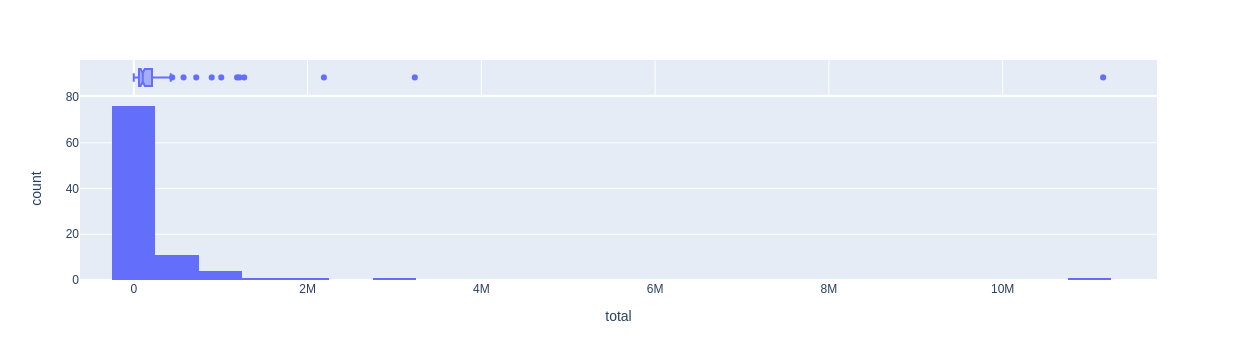

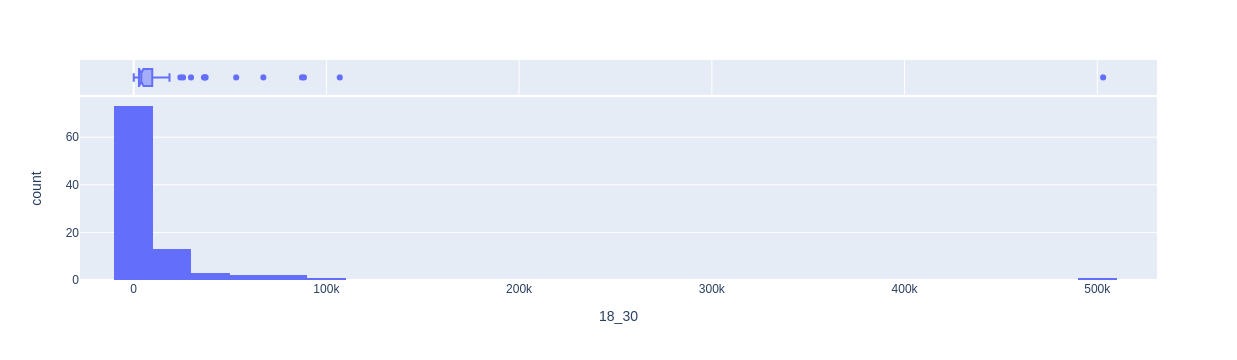

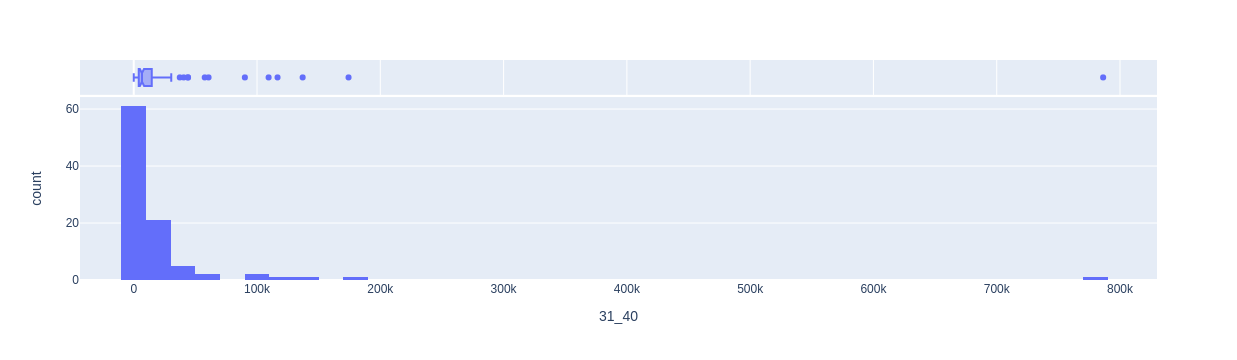

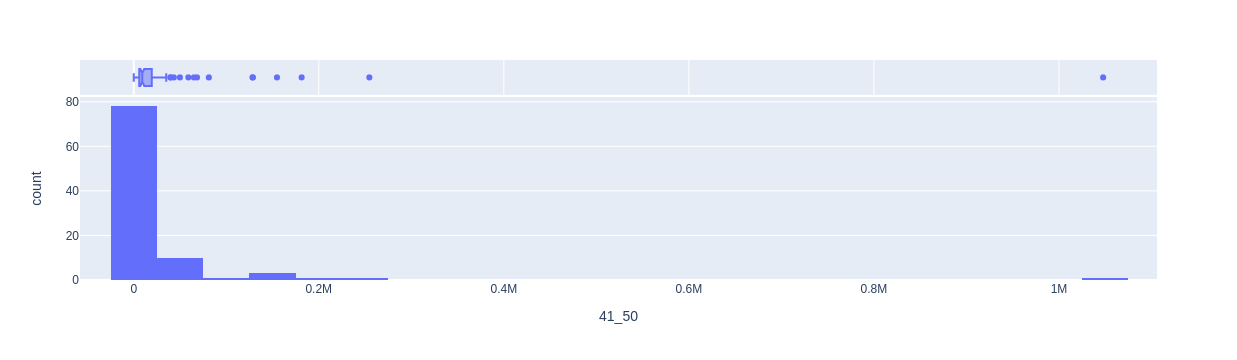

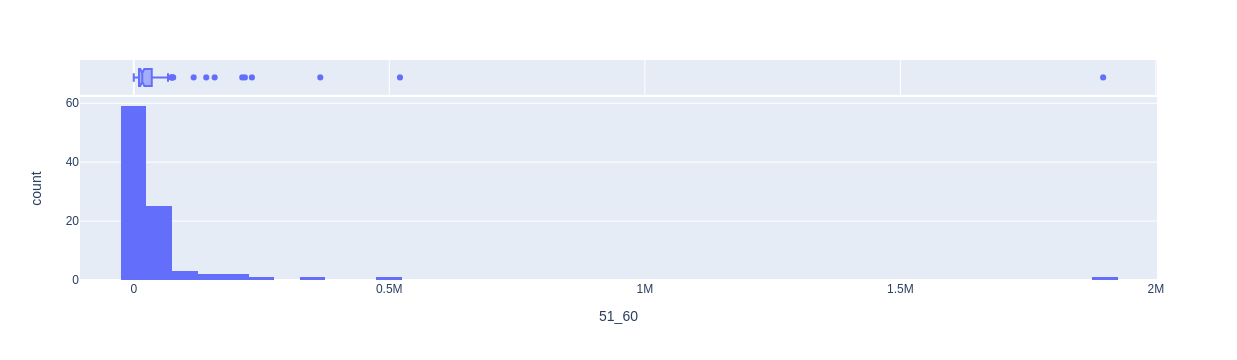

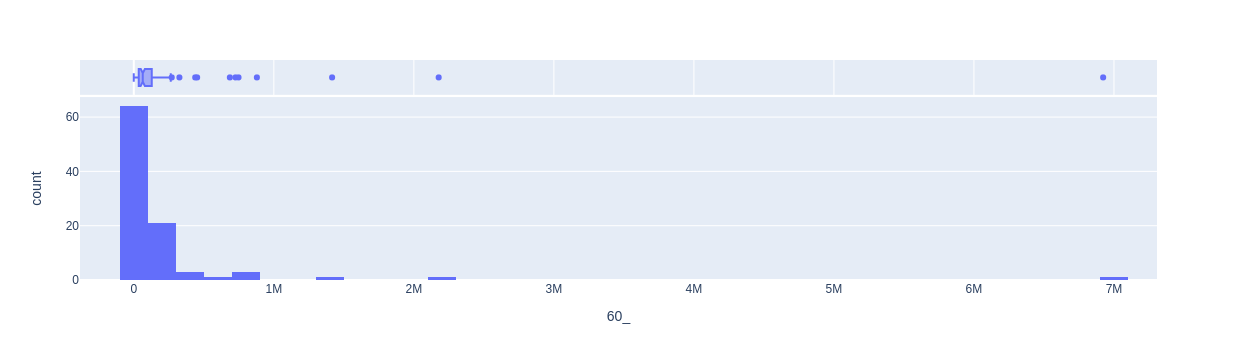

In [72]:
for i, col in enumerate(last.columns[1:]):
    fig = px.histogram(last, x = col, nbins = 50, marginal='box', width = 800)
    fig.show()

In [13]:
merged_df = merged_df.merge(last, how='left', on='region')
merged_df.shape

(85, 13)

In [14]:
sheet_names = ['alco', 'drugs']

df_1 = pd.read_excel('data/drug_alco.xlsx', sheet_name=sheet_names[0])
df_2 = pd.read_excel('data/drug_alco.xlsx', sheet_name=sheet_names[1])

df_1['alco'] = [round(df_1.iloc[i, 1:].mean(), 2) for i in range(df_1.shape[0])]
df_1 = df_1.loc[:, ['region', 'alco']]

df_2['drug'] = [round(df_2.iloc[i, 1:].mean(), 2) for i in range(df_2.shape[0])]
df_2 = df_2.loc[:, 'drug']

df_drug_alco = pd.concat([df_1, df_2], axis=1)
df_drug_alco

region   alco  drug
0            Российская Федерация 101.68 15.92
1   Центральный федеральный округ  96.12 13.05
2            Белгородская область  76.48  4.22
3                Брянская область 169.42 14.05
4            Владимирская область 121.35  9.74
..                            ...    ...   ...
87               Амурская область 119.93 25.68
88            Магаданская область 346.14 20.57
89            Сахалинская область 315.03 29.80
90   Еврейская автономная область 174.60 28.57
91     Чукотский автономный округ 486.02  2.85

[92 rows x 3 columns]

In [18]:
print(set(merged_df['region'].values).difference(df_drug_alco['region'].values))
print(set(df_drug_alco['region'].values).difference(merged_df['region'].values))

{'Город федерального значения Севастополь', 'Республика Адыгея (Адыгея)', 'Архангельская область (кроме Ненецкого автономного округа)', 'Город Москва столица Российской Федерации город федерального значения', 'Город Санкт-Петербург город федерального значения', 'Республика Крым', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Кемеровская область - Кузбасс'}
{'Сибирский федеральный округ', 'Кемеровская область', 'Южный федеральный округ  (до 03.06.2014)', 'г. Санкт-Петербург', 'Уральский федеральный округ', 'Архангельская область', 'Республика Адыгея (Адыгея) (до 03.06.2014)', 'Российская Федерация', 'Приволжский федеральный округ', 'Северо-Кавказский федеральный округ (до 03.06.2014)', 'Центральный федеральный округ', 'Северо-Западный федеральный округ', 'г. Москва', 'Тюменская область', 'Дальневосточный федеральный округ'}


In [15]:
df_drug_alco.loc[df_drug_alco['region'] == 'Кемеровская область', 'region'] = 'Кемеровская область - Кузбасс'
df_drug_alco.loc[df_drug_alco['region'] == 'г. Москва', 'region'] = 'Город Москва столица Российской Федерации город федерального значения'
df_drug_alco.loc[df_drug_alco['region'] == 'г. Санкт-Петербург', 'region'] = 'Город Санкт-Петербург город федерального значения'
df_drug_alco.loc[df_drug_alco['region'] == 'Республика Адыгея (Адыгея) (до 03.06.2014)', 'region'] = 'Республика Адыгея (Адыгея)'


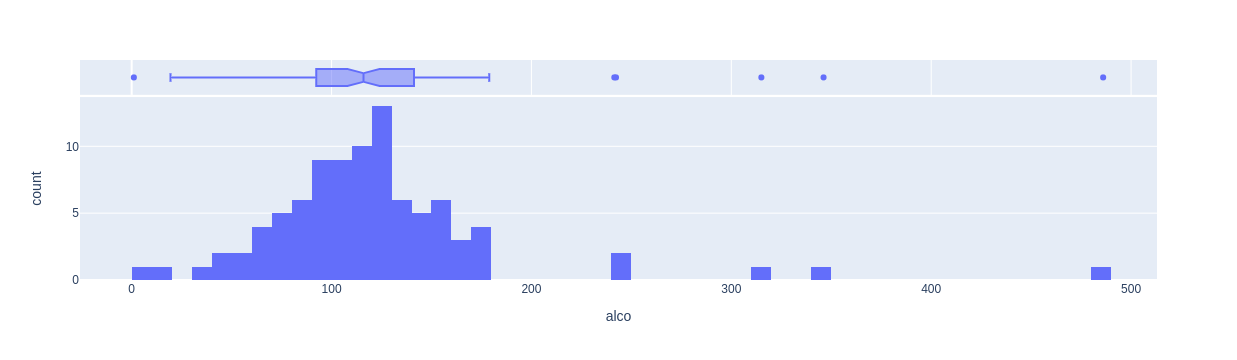

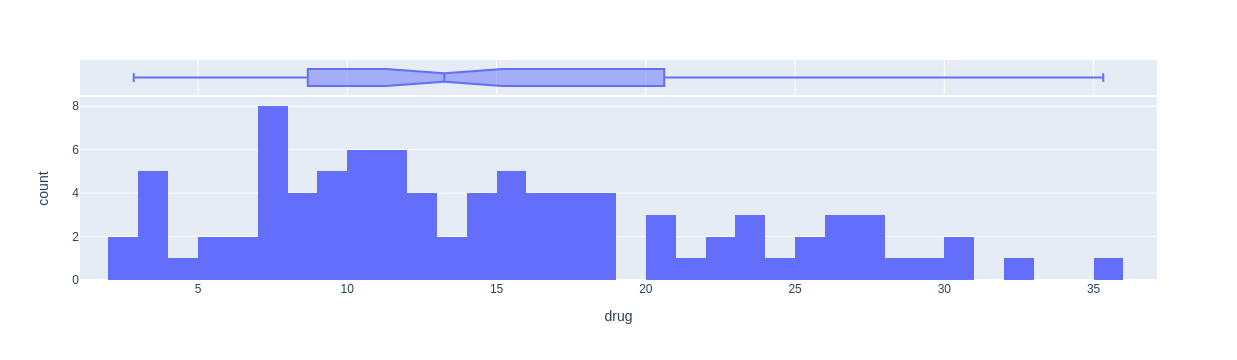

In [79]:
for i, col in enumerate(df_drug_alco.columns[1:]):
    fig = px.histogram(df_drug_alco, x = col, nbins = 50, marginal='box', width = 800)
    fig.show()

In [16]:
merged_df = merged_df.merge(df_drug_alco, how='left', on='region')
merged_df.shape

(85, 15)

In [17]:
df_grp = pd.read_excel('data/gross_regional_product_1996_2020.xls', header=2)

df_grp.rename(columns = {'Unnamed: 0':'region'}, inplace=True)
df_grp['region'] = df_grp['region'].apply(lambda arg: ' '.join(arg.split()))
df_grp['grp'] = [round(df_grp.iloc[i, 1:].mean(), 2) for i in range(df_grp.shape[0])]
df_grp = df_grp.loc[:, ['region', 'grp']]

df_grp

region       grp
0             Российская Федерация 257637.96
1    Центральный федеральный округ 365468.74
2             Белгородская область 244680.47
3                 Брянская область 123532.82
4             Владимирская область 149340.34
..                             ...       ...
96             Магаданская область 488520.87
97             Сахалинская область 860733.34
98    Еврейская автономная область 157024.00
99      Чукотский автономный округ 724122.68
100     Крымский федеральный округ  34263.10

[101 rows x 2 columns]

In [22]:
print(set(merged_df['region'].values).difference(df_grp['region'].values))
print(set(df_grp['region'].values).difference(merged_df['region'].values))

set()
{'Сибирский федеральный округ', 'Северо-Кавказский федеральный округ', 'Южный федеральный округ (по 2009 год)', 'Уральский федеральный округ', 'Крымский федеральный округ', 'Архангельская область', 'Российская Федерация', 'Приволжский федеральный округ', 'Центральный федеральный округ', 'Северо-Западный федеральный округ', 'Южный федеральный округ (с 29.07.2016)', 'Южный федеральный округ (с 2010 года)', 'Тюменская область', 'Дальневосточный федеральный округ'}


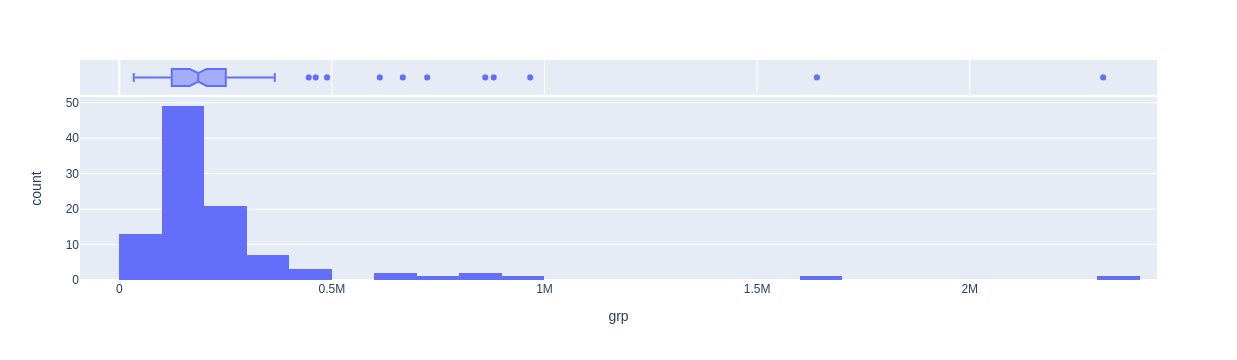

In [83]:
fig = px.histogram(df_grp, x = 'grp', marginal = 'box', nbins = 25, width = 800)
fig.show()

In [18]:
merged_df = merged_df.merge(df_grp, how='left', on='region')
merged_df.shape

(85, 16)

In [19]:
df_housing = pd.DataFrame()
sheet_names = ['housing_cond', 'housing_intent']

df_1 = pd.read_excel('data/housing_2020.xlsx', sheet_name=sheet_names[0])
df_2 = pd.read_excel('data/housing_2020.xlsx', sheet_name=sheet_names[1])

df_1.rename(columns={'Регион':'region'}, inplace=True)

df_2.drop('Регион', axis=1, inplace=True)
df_2.drop([94, 95], axis=0, inplace=True)

df_housing = pd.concat([df_1, df_2], axis = 1)
df_housing.drop(['Число домохозяйств, проживающих во всех типах жилых помещений', 'Все домохозяйства'], axis=1, inplace=True)

df_housing.drop('затруднились ответить', axis=1, inplace=True)

df_housing.shape

(94, 18)

In [25]:
print(set(merged_df['region'].values).difference(df_housing['region'].values))
print(set(df_housing['region'].values).difference(merged_df['region'].values))

{'Ненецкий автономный округ (Архангельская область)', 'Еврейская автономная область', 'Архангельская область (кроме Ненецкого автономного округа)', 'Республика Саха (Якутия)', 'Волгоградская область', 'Чувашская Республика - Чувашия', 'Ямало-Ненецкий автономный округ (Тюменская область)', 'Чукотский автономный округ', 'Воронежская область', 'Город федерального значения Севастополь', 'Республика Адыгея (Адыгея)', 'Вологодская область', 'Город Москва столица Российской Федерации город федерального значения', 'Город Санкт-Петербург город федерального значения', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Кемеровская область - Кузбасс', 'Республика Татарстан (Татарстан)', 'Владимирская область', 'Ханты-Мансийский автономный округ - Югра (Тюменская область)'}
{'Архангельская область без авт. округа', 'Кемеровская область', 'Еврейская авт. область', 'Bоронежская область', 'Ямало-Ненецкий авт. округ', 'Южный федеральный округ', 

In [20]:
df_housing.loc[df_housing['region'] == 'Чукотский авт. округ', 'region'] = 'Чукотский автономный округ'
df_housing.loc[df_housing['region'] == 'Ямало-Ненецкий авт. округ', 'region'] = 'Ямало-Ненецкий автономный округ (Тюменская область)'
df_housing.loc[df_housing['region'] == 'Еврейская авт. область', 'region'] = 'Еврейская автономная область'
df_housing.loc[df_housing['region'] == 'г. Санкт-Петербург', 'region'] = 'Город Санкт-Петербург город федерального значения'
df_housing.loc[df_housing['region'] == 'Республика Саха(Якутия)', 'region'] = 'Республика Саха (Якутия)'
df_housing.loc[df_housing['region'] == 'Тюменская область без авт. округов', 'region'] = 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'
df_housing.loc[df_housing['region'] == 'Республика Татарстан', 'region'] = 'Республика Татарстан (Татарстан)'
df_housing.loc[df_housing['region'] == 'Архангельская область без авт. округа', 'region'] = 'Архангельская область (кроме Ненецкого автономного округа)'
df_housing.loc[df_housing['region'] == 'Республика Адыгея', 'region'] = 'Республика Адыгея (Адыгея)'
df_housing.loc[df_housing['region'] == 'Чувашская Республика', 'region'] = 'Чувашская Республика - Чувашия'
df_housing.loc[df_housing['region'] == 'г.Москва', 'region'] = 'Город Москва столица Российской Федерации город федерального значения'
df_housing.loc[df_housing['region'] == 'г. Севастополь', 'region'] = 'Город федерального значения Севастополь'
df_housing.loc[df_housing['region'] == 'Bолгоградская область', 'region'] = 'Волгоградская область'
df_housing.loc[df_housing['region'] == 'Кемеровская область', 'region'] = 'Кемеровская область - Кузбасс'
df_housing.loc[df_housing['region'] == 'Ханты-Мансийский авт. округ', 'region'] = 'Ханты-Мансийский автономный округ - Югра (Тюменская область)'
df_housing.loc[df_housing['region'] == 'Bологодская область', 'region'] = 'Вологодская область'
df_housing.loc[df_housing['region'] == 'Bладимирская область', 'region'] = 'Владимирская область'
df_housing.loc[df_housing['region'] == 'Bоронежская область', 'region'] = 'Воронежская область'
df_housing.loc[df_housing['region'] == 'Ненецкий авт. округ', 'region'] = 'Ненецкий автономный округ (Архангельская область)'

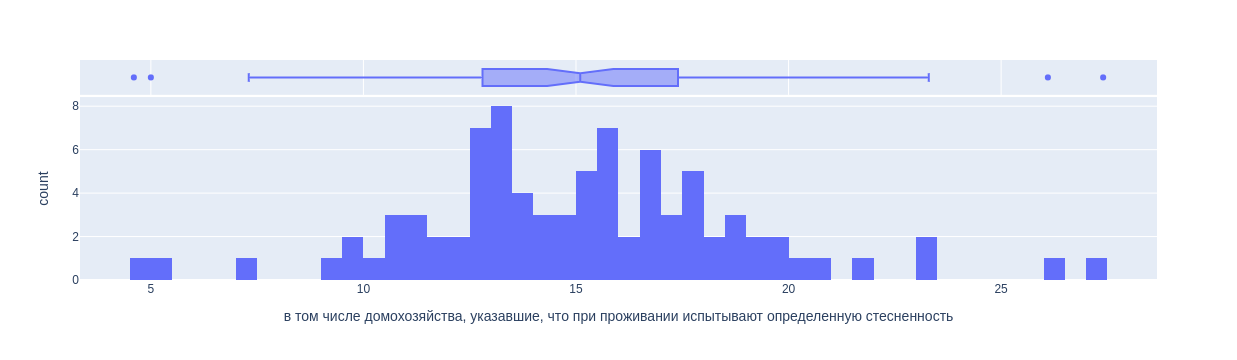

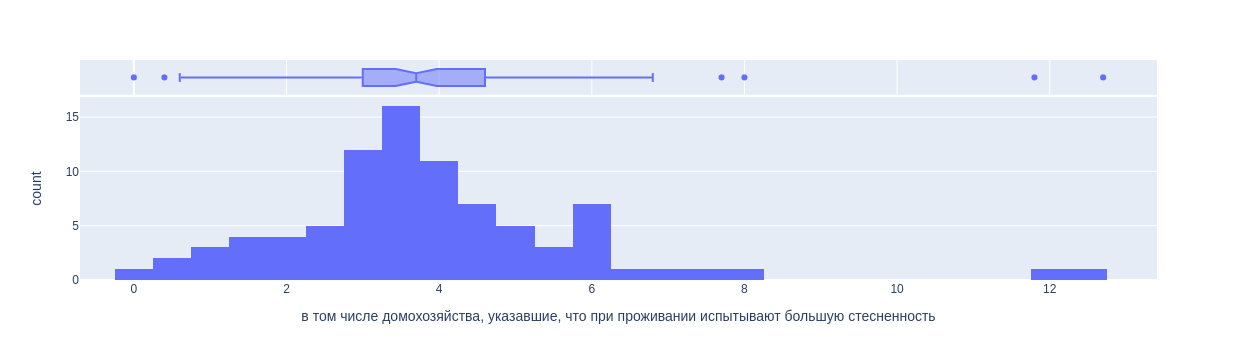

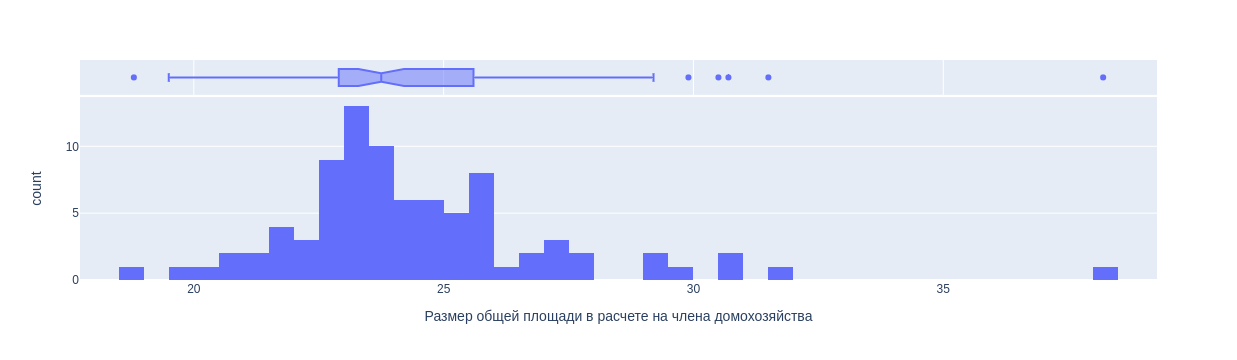

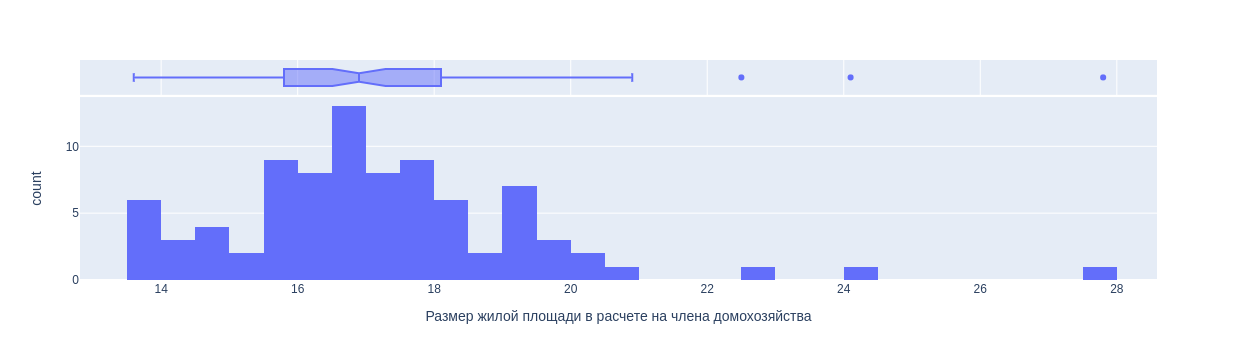

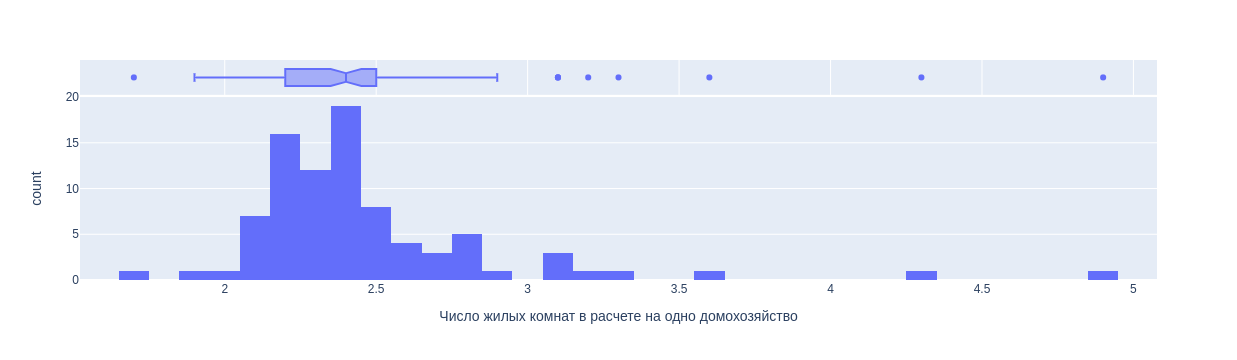

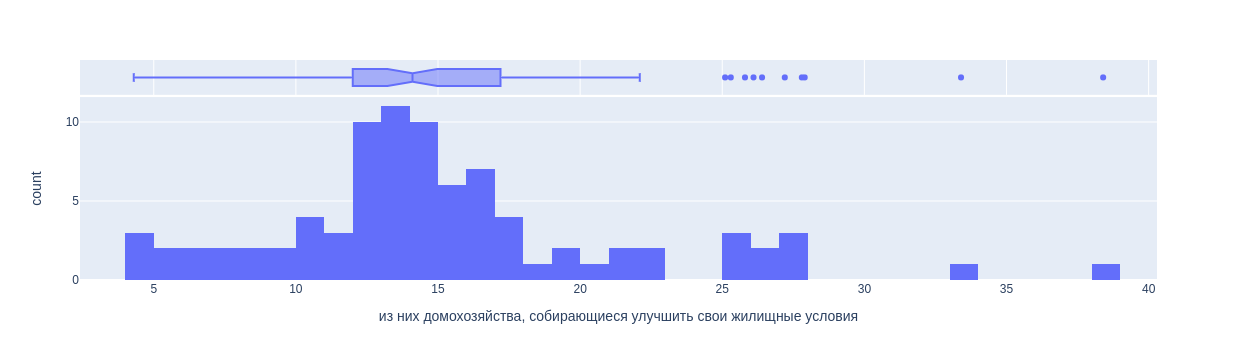

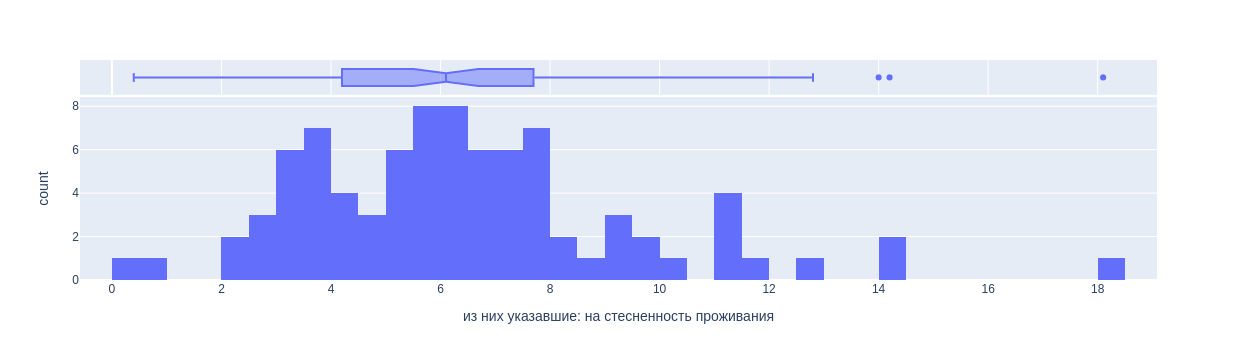

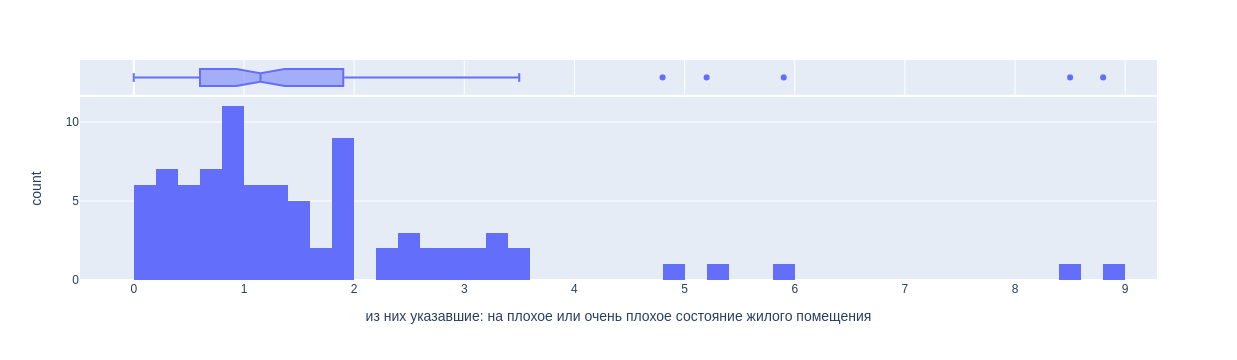

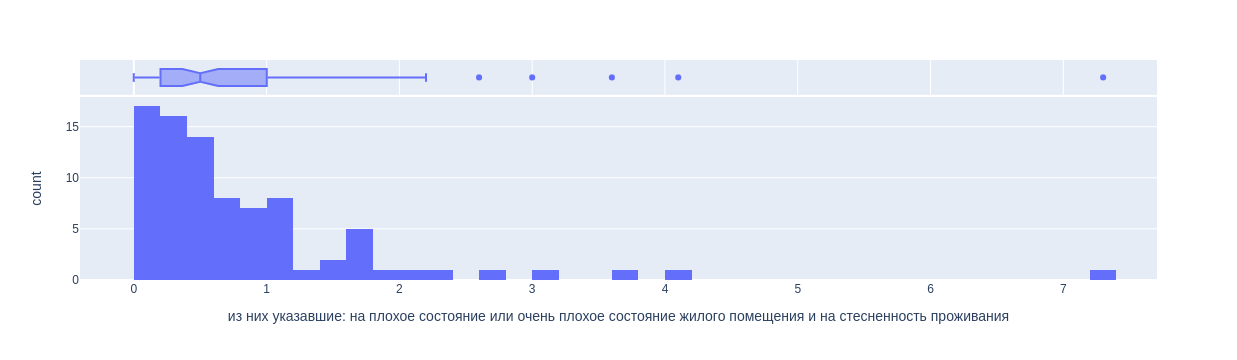

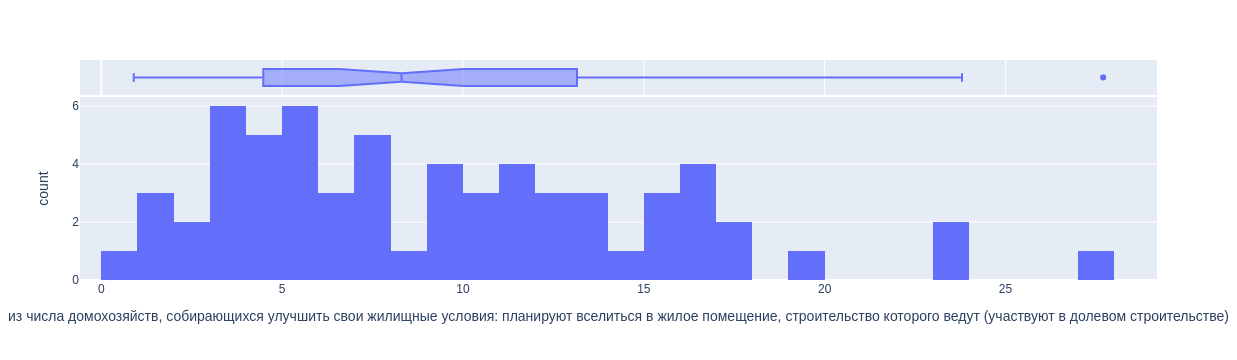

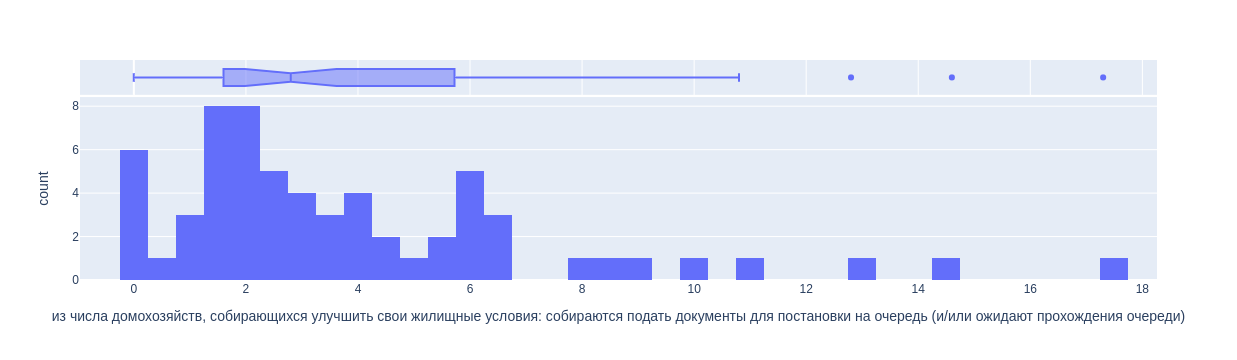

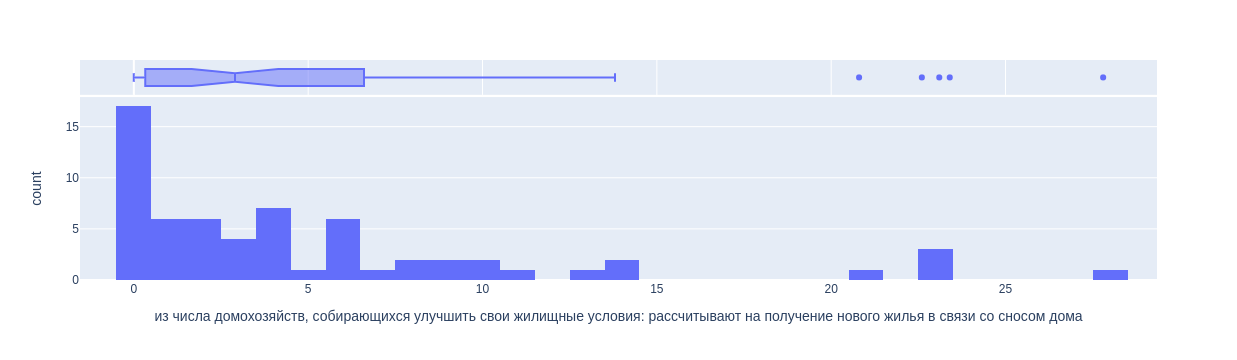

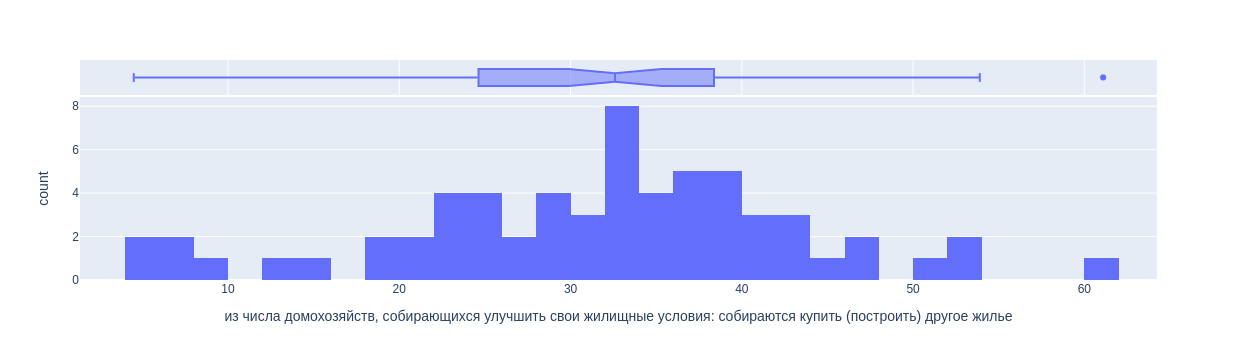

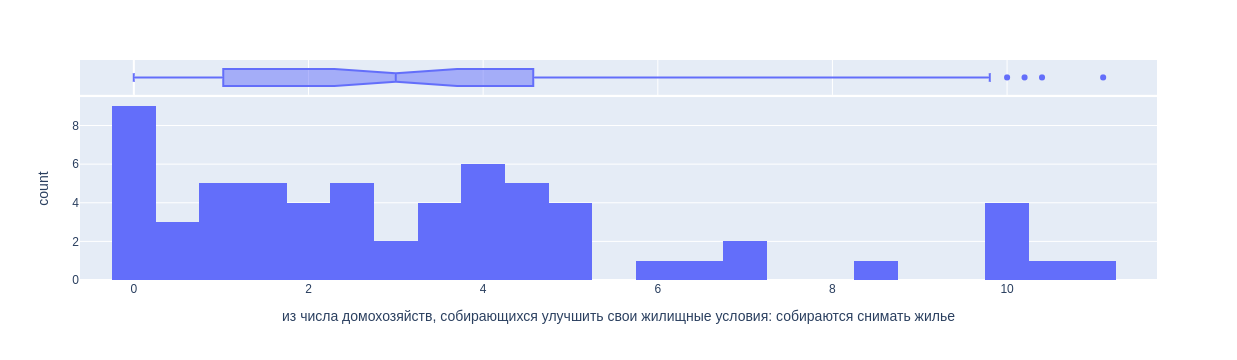

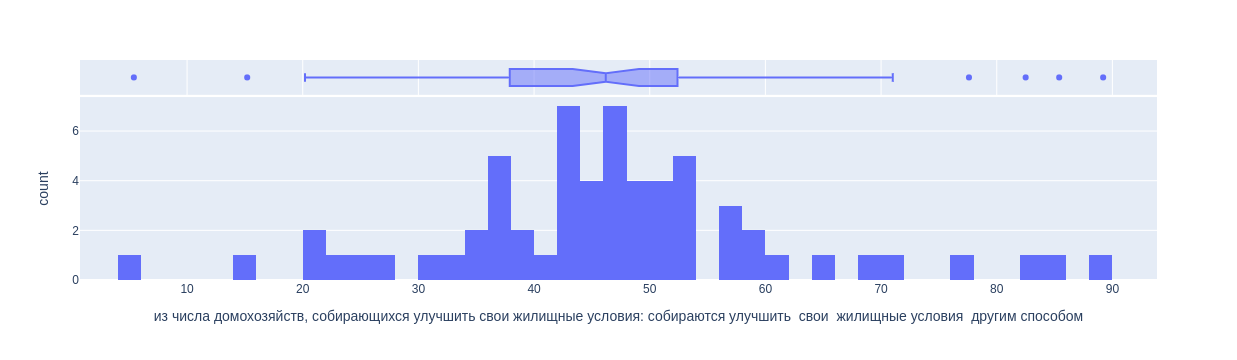

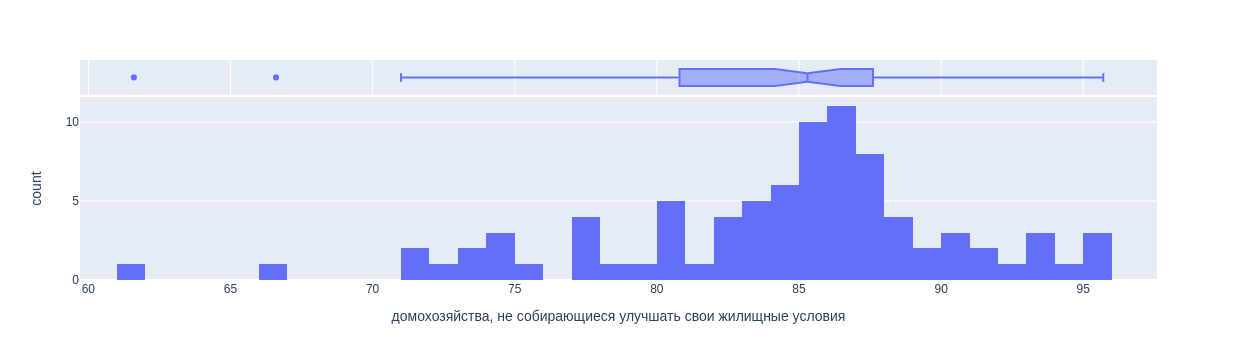

In [98]:
for i, col in enumerate(df_housing.columns[1:]):
    fig = px.histogram(df_housing, x = col, nbins = 50, marginal='box', width = 800)
    fig.show()

In [21]:
merged_df = merged_df.merge(df_housing, how='left', on='region')
merged_df.shape

(85, 33)

In [22]:
new_born_df = pd.read_csv('data/newborn_2006_2022_monthly.csv', sep=';')

new_born_df.rename(columns={'Region':'region', 'авст 2006 г.':'август 2006 г.'}, inplace=True)

new_born_df.dropna(axis=0, thresh=new_born_df.shape[1]*0.6, inplace=True)
new_born_df.dropna(axis=1, how='all', inplace=True)
new_born_df.drop(0, axis=0, inplace=True)

for col in new_born_df.columns:
    if col != 'region':
        new_born_df[col] = new_born_df[col].apply(lambda arg: re.sub(r'\,', '.', arg) if type(arg) == str else arg)
        new_born_df[col].astype('float')
        
new_born_df

region январь 2006 г. февраль 2006 г.  \
1    Центральный федеральный округ       24998.99        25539.99   
2             Белгородская область           1040            1094   
3                 Брянская область            904             989   
4             Владимирская область           1040            1059   
5              Воронежская область           1301            1479   
..                             ...            ...             ...   
101               Амурская область            816             767   
102            Магаданская область            145             141   
103            Сахалинская область            448             419   
104   Еврейская автономная область            176             169   
105     Чукотский автономный округ             44              77   

    март 2006 г. апрель 2006 г. май 2006 г. июнь 2006 г. июль 2006 г.  \
1       29558.99          25781       29137        28837     28997.99   
2           1190           1044        1228         1249         1224   
3           1039            936        1072          961         1058   
4           1236           1063        1226         1144         1221   
5           1689           1513        1729         1555         1620   
..           ...            ...         ...          ...          ...   
101          899            825         859          928          883   
102          157            151         188          134          163   
103          507            479         503          490          504   
104          215            141         168          182          218   
105           60             53          57           59           86   

    август 2006 г. сентябрь 2006 г.  ... август 2021 г. сентябрь 2021 г.  \
1         31590.99         27755.99  ...       31329.99            29727   
2             1389             1157  ...           1154             1084   
3             1121              989  ...            835              784   
4             1333             1177  ...            864              783   
5             1897             1554  ...           1708             1643   
..             ...              ...  ...            ...              ...   
101           1014              841  ...            654              619   
102            147              149  ...             89              121   
103            557              510  ...            517              434   
104            225              196  ...            125              164   
105             58               64  ...             33               24   

    октябрь 2021 г. ноябрь 2021 г. декабрь 2021 г. январь 2022 г.  \
1          29532.99          29093           29477          25827   
2              1053            990            1028            861   
3               751            783             729            707   
4               834            769             821            691   
5              1278           1758            1584           1342   
..              ...            ...             ...            ...   
101             615            546             617            592   
102              89             91             119             91   
103             429            420             456            409   
104             119            139             133            120   
105              54             35              40             42   

    февраль 2022 г. март 2022 г. апрель 2022 г. май 2022 г.  
1             25678        28086       24979.99       26304  
2               941          956            801         869  
3               670          740            589         660  
4               700          708            660         711  
5              1326         1576           1309        1319  
..              ...          ...            ...         ...  
101             527          634            529         534  
102              86          110             89          79  
103             345   

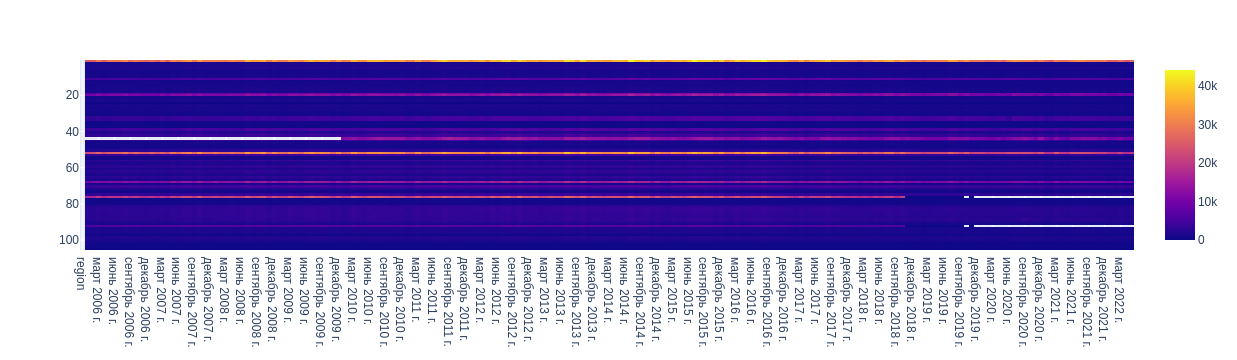

In [28]:
fig = px.imshow(new_born_df)
fig.show()

Объеденим месяцы в годы. Затем создадим новый признак со средним знаением по годам и оставим в датасете в качестве признаков регионы и среднее по годам. 

In [23]:
for col in new_born_df.columns[1:]:
    new_born_df[col] = new_born_df[col].astype('float')
    
n_1 = 1
n_2 = 13
new_born = pd.DataFrame({'region':new_born_df['region']})

for year in range(2006, 2023):
    df = new_born_df.iloc[:, n_1:n_2]
    df[year] = [df.iloc[i].sum() for i in range(df.shape[0])]
    df = df[year]
    new_born = pd.concat([new_born, df], axis=1)
    n_1 += 12
    n_2 += 12

new_born['new_born'] = [new_born.iloc[i, -7:-2].mean() for i in range(new_born.shape[0])]
new_born = new_born.loc[:, ['region', 'new_born']]

new_born

region  new_born
1    Центральный федеральный округ 396414.34
2             Белгородская область  14448.40
3                 Брянская область  11112.80
4             Владимирская область  12598.60
5              Воронежская область  21509.40
..                             ...       ...
101               Амурская область   8893.60
102            Магаданская область   1448.40
103            Сахалинская область   6112.99
104   Еврейская автономная область   1859.80
105     Чукотский автономный округ    602.60

[90 rows x 2 columns]

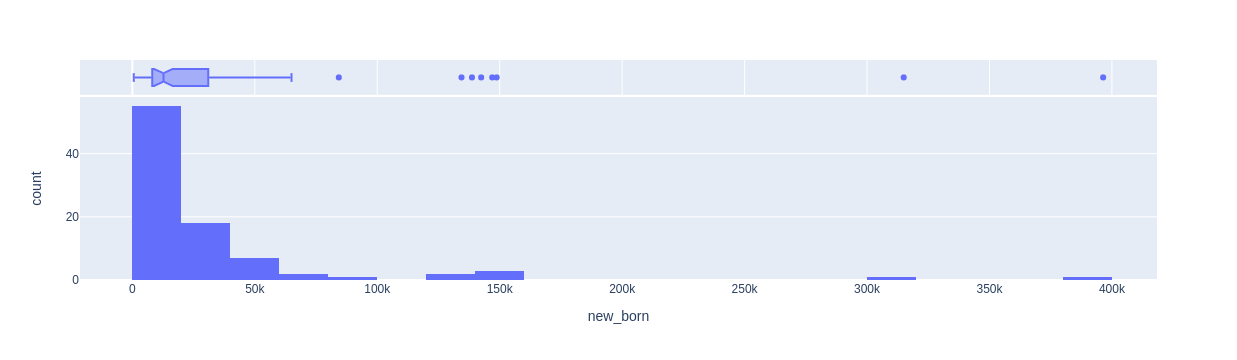

In [104]:
fig = px.histogram(new_born, x = 'new_born', nbins=25, marginal='box', width = 800)
fig.show()

In [33]:
print(set(merged_df['region'].values).difference(new_born['region'].values))
print(set(new_born['region'].values).difference(merged_df['region'].values))

{'Республика Крым', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Город федерального значения Севастополь', 'Архангельская область (кроме Ненецкого автономного округа)'}
{'Сибирский федеральный округ', 'Северо-Кавказский федеральный округ', 'Уральский федеральный округ', 'Архангельская область', 'Приволжский федеральный округ', 'Центральный федеральный округ', 'Северо-Западный федеральный округ', 'Тюменская область', 'Дальневосточный федеральный округ'}


In [24]:
merged_df = merged_df.merge(new_born, how='left', on='region')
merged_df.shape

(85, 34)

In [25]:
population = pd.read_excel('data/population.xlsx', header = 1)

population.drop('Unnamed: 1', axis=1, inplace=True)
population.rename(columns={'Unnamed: 0':'region'}, inplace=True)

for i in range(2, population.shape[0]):
    population.loc[i-1, population.columns != 'region'] = population.loc[i, population.columns != 'region']

population.dropna(axis=0, thresh= 15, inplace=True)

population

region  январь 1999 г.  январь 2000 г.  \
1             Российская Федерация    147539426.00    146890128.00   
3    Центральный федеральный округ     38311159.00     38227656.00   
5             Белгородская область      1494868.00      1501699.00   
7                 Брянская область      1437471.00      1423178.00   
9             Владимирская область      1592184.00      1575507.00   
..                             ...             ...             ...   
356               Амурская область       949526.00       935607.00   
358            Магаданская область       211696.00       201974.00   
360            Сахалинская область       581305.00       569234.00   
362   Еврейская автономная область       199172.00       195135.00   
364     Чукотский автономный округ        67010.00        61613.00   

     январь 2001 г.  январь 2002 г.  январь 2003 г.  январь 2004 г.  \
1      146303611.00    145649334.00    144963650.00    144333586.00   
3       38175094.00     38068452.00     37946810.00     37965073.00   
5        1506976.00      1508137.00      1511899.00      1513860.00   
7        1407965.00      1391430.00      1375004.00      1360249.00   
9        1558052.00      1539179.00      1520057.00      1509571.00   
..              ...             ...             ...             ...   
356       923055.00       911381.00       901044.00       887781.00   
358       193945.00       187218.00       181832.00       178069.00   
360       560049.00       552155.00       545008.00       536783.00   
362       193198.00       191899.00       190585.00       188412.00   
364        57534.00        55309.00        53137.00        51933.00   

     январь 2005 г.  январь 2006 г.  январь 2007 г.  ...  январь 2013 г.  \
1      143801046.00    143236582.00    142862692.00  ...    143347059.00   
3       38044068.00     38109006.00     38183357.00  ...     38678913.00   
5        1511662.00      1511715.00      1514153.00  ...      1540985.00   
7        1344132.00      1327652.00      1312748.00  ...      1253666.00   
9        1497598.00      1486453.00      1475861.00  ...      1421742.00   
..              ...             ...             ...  ...             ...   
356       874018.00       861056.00       850502.00  ...       816910.00   
358       173937.00       170397.00       166902.00  ...       152358.00   
360       529813.00       521121.00       513452.00  ...       493302.00   
362       185763.00       181653.00       179405.00  ...       172671.00   
364        51815.00        52391.00        52913.00  ...        50780.00   

     январь 2014 г.  январь 2015 г.  январь 2016 г.  январь 2017 г.  \
1      143666931.00    146267288.00    146544710.00    146804372.00   
3       38819874.00     38951479.00     39104319.00     39209582.00   
5        1544108.00      1547936.00      1550137.00      1552865.00   
7        1242599.00      1232940.00      1225741.00      1220530.00   
9        1413321.00      1405613.00      1397168.00      1389599.00   
..              ...             ...             ...             ...   
356       811274.00       809873.00       805689.00       801752.00   
358       150312.00       148071.00       146345.00       145570.00   
360       491027.00       488391.00       487293.00       487344.00   
362       170377.00       168368.00       166120.00       164217.00   
364        50555.00        50540.00        50157.00        49822.00   

     январь 2018 г.  январь 2019 г.  январь 2020 г.  январь 2021 г.  \
1      146880432.00    146780720.00    146748590.00    146171015.00   
3       39311413.00     39378059.00     39433556.00     39250960.00   
5        1549876.00      1547418.00      1549151.00      1541259.00   
7        1210982.00      1200187.00      1192491.00      1182682.00   
9        1378337.00      1365805.00      1358416.00      1342099.00   
..              ...             ...             ...             ...   
356       798424.00       793194.00       790044.00       781846.00   


In [26]:
population['population'] = [population.iloc[i, -10:].mean() for i in range(population.shape[0])]
population = population.loc[:, ['region', 'population']]
population

region   population
1             Российская Федерация 145876869.30
3    Центральный федеральный округ  39124255.50
5             Белгородская область   1545565.20
7                 Брянская область   1213058.90
9             Владимирская область   1379575.90
..                             ...          ...
356               Амурская область    798153.10
358            Магаданская область    144493.10
360            Сахалинская область    488523.10
362   Еврейская автономная область    163231.60
364     Чукотский автономный округ     50072.00

[93 rows x 2 columns]

In [43]:
print(set(merged_df['region'].values).difference(population['region'].values))
print(set(population['region'].values).difference(merged_df['region'].values))

{'Республика Крым', 'Город федерального значения Севастополь'}
{'Сибирский федеральный округ', 'Северо-Западный федеральный округ', 'Северо-Кавказский федеральный округ', 'Дальневосточный федеральный округ', 'Приволжский федеральный округ', 'Российская Федерация', 'Уральский федеральный округ', 'Центральный федеральный округ'}


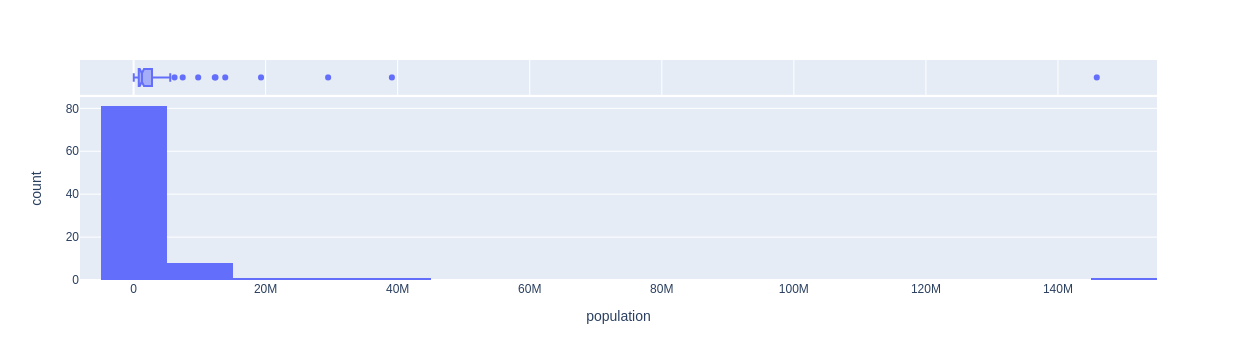

In [112]:
fig = px.histogram(population, x = 'population', nbins=25, marginal='box', width = 800)
fig.show()

In [27]:
merged_df = merged_df.merge(population, how='left', on='region')
merged_df.shape

(85, 35)

In [28]:
poverty = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')

poverty = poverty.groupby('region')['poverty_percent'].mean()
poverty = poverty.reset_index()

poverty['region'] = poverty['region'].apply(lambda arg: ' '.join(arg.split()))
poverty

region  poverty_percent
0   Архангельская область (кроме Ненецкого автоном...            13.83
1   Ненецкий автономный округ (Архангельская область)             9.05
2   Тюменская область (кроме Ханты-Мансийского авт...            13.57
3   Ханты-Мансийский автономный округ - Югра (Тюме...             7.83
4   Ямало-Ненецкий автономный округ (Тюменская обл...             5.75
..                                                ...              ...
93                        Уральский федеральный округ             0.00
94                      Центральный федеральный округ             0.00
95              Южный федеральный округ (с 2010 года)             0.00
96             Южный федеральный округ (с 29.07.2016)             0.00
97                               Российская Федерация            18.38

[98 rows x 2 columns]

In [48]:
print(set(merged_df['region'].values).difference(poverty['region'].values))
print(set(poverty['region'].values).difference(merged_df['region'].values))

set()
{'Южный федеральный округ (с 29.07.2016)', 'Дальневосточный федеральный округ', 'Северо-Западный федеральный округ', 'Приволжский федеральный округ', 'Сибирский федеральный округ', 'Российская Федерация', 'Крымский федеральный округ', 'Северо-Кавказский федеральный округ', 'Уральский федеральный округ', 'Южный федеральный округ (с 2010 года)', 'Центральный федеральный округ'}


In [29]:
merged_df = merged_df.merge(poverty, how='left', on='region')
merged_df.shape

(85, 36)

In [30]:
df = pd.read_excel('data/poverty_socdem_2017.xls', header=2)
df.rename(columns={'Unnamed: 0':'region'}, inplace=True)
df.drop('Все население', axis=1, inplace=True)

for col in df.columns:
    if col != 'region':
        df.rename(columns={col:f'2017_{col}'}, inplace=True)

df_2 = pd.read_excel('data/poverty_socdem_2018.xls', header=2)
df_2.drop(['Все население', 'Unnamed: 0'], axis=1, inplace=True)

for col in df_2.columns:
    df_2.rename(columns={col:f'2018_{col}'}, inplace=True)
    
df_3 = pd.read_excel('data/poverty_socdem_2019.xls', header=2)
df_3.drop(['Все население', 'Unnamed: 0'], axis=1, inplace=True)

for col in df_3.columns:
    df_3.rename(columns={col:f'2019_{col}'}, inplace=True)
    
    
df_4 = pd.read_excel('data/poverty_socdem_2020.xls', header=2)
df_4.drop(['Все население', 'Unnamed: 0'], axis=1, inplace=True)

for col in df_4.columns:
    df_4.rename(columns={col:f'2020_{col}'}, inplace=True)
    
poverty = pd.concat([df, df_2, df_3, df_4], axis=1)
poverty['region'] = poverty['region'].apply(lambda x: ' '.join(x.split()))
# poverty.dropna(axis=0, thresh=1, inplace=True)
poverty

region  2017_Дети в возрасте до 16 лет  \
0           Российская Федерация                           39.30   
1           Белгородская область                           43.40   
2               Брянская область                           42.90   
3           Владимирская область                           34.80   
4            Воронежская область                           38.60   
..                           ...                             ...   
83              Амурская область                           39.90   
84           Магаданская область                           32.20   
85           Сахалинская область                           36.40   
86  Еврейская автономная область                           36.00   
87    Чукотский автономный округ                           46.90   

    2017_Население старше трудоспособного возраста  \
0                                             6.60   
1                                            11.80   
2                                             4.90   
3                                             8.60   
4                                             5.90   
..                                             ...   
83                                            6.00   
84                                           14.80   
85                                            6.40   
86                                            9.90   
87                                            2.70   

    2017_Население трудоспособного возраста  2018_Дети в возрасте до 16 лет  \
0                                     54.10                           39.90   
1                                     44.80                           44.80   
2                                     52.20                           40.30   
3                                     56.60                           48.90   
4                                     55.60                           32.60   
..                                      ...                             ...   
83                                    54.10                           40.60   
84                                    53.00                           30.70   
85                                    57.10                           32.90   
86                                    54.10                           33.70   
87                                    50.40                           51.00   

    2018_Население старше трудоспособного возраста  \
0                                             6.50   
1                                            12.90   
2                                             1.80   
3                                             8.30   
4                                             8.00   
..                                             ...   
83                                            4.60   
84                                           11.50   
85                                            4.30   
86                                            7.40   
87                                            0.00   

    2018_Население трудоспособного возраста  2019_Дети в возрасте до 16 лет  \
0                                     53.70                           41.00   
1                                     42.30                            0.00   
2                                     57.90                           37.50   
3                                     42.80                           34.80   
4                                     59.40                           45.20   
..                                      ...                             ...   
83                                    54.80                           33.90   
84                                    57.80                           45.80   
85                                    62.80                           44.90   
86                                    58.90                           32.00   
87                                    49.00                            0.00   

    2019_Насе

In [31]:
poverty['Дети в возрасте до 16 лет'] = (poverty['2017_Дети в возрасте до 16 лет'] + poverty['2018_Дети в возрасте до 16 лет'] + poverty['2019_Дети в возрасте до 16 лет']) / 3
poverty['Население старше трудоспособного возраста'] = (poverty['2017_Население старше трудоспособного возраста'] + poverty['2018_Население старше трудоспособного возраста'] +poverty['2019_Население старше трудоспособного возраста']) / 3
poverty['Население трудоспособного возраста'] = (poverty['2017_Население трудоспособного возраста'] + poverty['2018_Население трудоспособного возраста'] + poverty['2019_Население трудоспособного возраста']) / 3
poverty = poverty.set_index('region').iloc[:, -3:]
poverty.reset_index(inplace=True)

In [43]:
print(set(merged_df['region'].values).difference(poverty['region'].values))
print(set(poverty['region'].values).difference(merged_df['region'].values))

{'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Архангельская область (кроме Ненецкого автономного округа)'}
{'Российская Федерация', 'Архангельская область (без АО)', 'Тюменская область', 'Тюменская область (без АО)', 'Архангельская область'}


In [32]:
poverty.loc[poverty['region'] == 'Архангельская область (без АО)', 'region'] = 'Архангельская область (кроме Ненецкого автономного округа)'
poverty.loc[poverty['region'] == 'Тюменская область (без АО)', 'region'] = 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'

In [33]:
merged_df = merged_df.merge(poverty, how='left', on='region')
merged_df.shape

(85, 39)

In [34]:
regional_production_1 = pd.read_csv('data/regional_production_2005_2016.csv')
regional_production_2 = pd.read_csv('data/regional_production_2017_2020.csv')

regional_production_1['regional_production'] = [regional_production_1.iloc[i, 2:].mean() for i in range(regional_production_1.shape[0])]
regional_production_1 = regional_production_1.loc[:, ['region', 'production_field', 'regional_production']]

regional_production_2['regional_production'] = [regional_production_2.iloc[i, 2:].mean() for i in range(regional_production_2.shape[0])]
regional_production_2 = regional_production_2.loc[:, ['region', 'production_field', 'regional_production']]

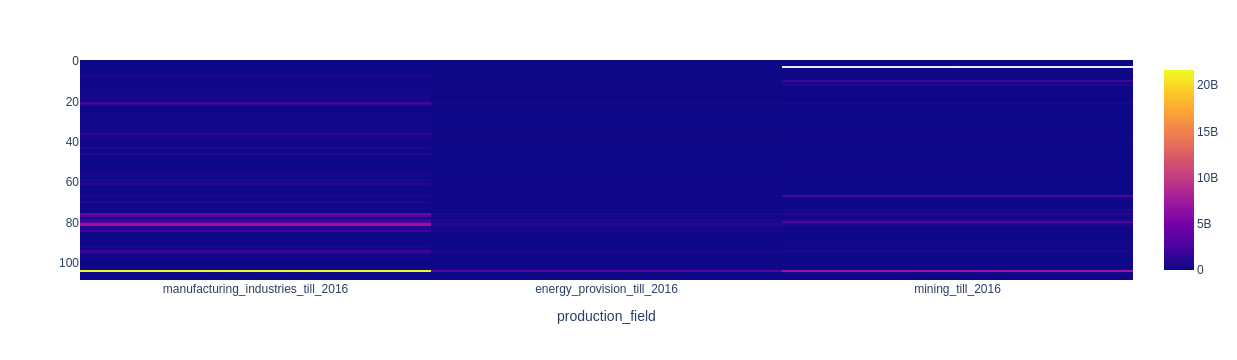

production_field                                             region  \
0                     Агинский Бурятский округ (Забайкальский край)   
1                                    Архангельская область (без АО)   
2                 Архангельская область (кроме Ненецкого автоном...   
3                 Коми-Пермяцкий округ, входящий в состав Пермск...   
4                 Корякский округ, входящий в состав Камчатского...   
..                                                              ...   
104                                            Российская Федерация   
105                                             Сахалинская область   
106                                                 Томская область   
107                                                Хабаровский край   
108                                      Чукотский автономный округ   

production_field  manufacturing_industries_till_2016  \
0                                          210836.07   
1                                       145889441.47   
2                                       153264700.35   
3                                          263100.90   
4                                         1106006.44   
..                                               ...   
104                                   21651076095.37   
105                                      25984076.21   
106                                     103176370.95   
107                                     113031594.23   
108                                        650298.25   

production_field  energy_provision_till_2016  mining_till_2016  
0                                  339558.13         203831.87  
1                                30228979.36        7004802.70  
2                                32467938.33       21566304.65  
3                                  191471.80               NaN  
4                                  911740.75        2142162.95  
..                                       ...               ...  
104                            3591648867.89     7226497099.20  
105                              14469981.26      397891352.45  
106                              23699064.35      112072039.28  
107                              39711845.19       34151876.75  
108                               7007433.12       36132855.22  

[109 rows x 4 columns]

In [35]:
pivot_prod_1 = pd.pivot_table(
    regional_production_1,
    index = 'region',
    columns = 'production_field',
    aggfunc = 'mean'
)

pivot_prod_1 = pivot_prod_1.loc[:, ('regional_production')]
pivot_prod_1.reset_index(inplace=True)
pivot_prod_1.dropna(axis=1, thresh=pivot_prod_1.shape[0] * 0.7, inplace=True)
pivot_prod_1.rename(columns={'РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА':'manufacturing_industries_till_2016', 'РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭНЕРГИИ, ГАЗА И ВОДЫ':'energy_provision_till_2016', 'РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ':'mining_till_2016'}, inplace=True)
pivot_prod_1['region'] = pivot_prod_1['region'].apply(lambda arg: ' '.join(arg.split()))

fig = px.imshow(pivot_prod_1.iloc[:, 1:])
fig.show()

pivot_prod_1 

In [58]:
print(set(merged_df['region'].values).difference(pivot_prod_1['region'].values))
print(set(pivot_prod_1['region'].values).difference(merged_df['region'].values))

set()
{'Эвенкийский автономный округ (Красноярский край)', 'Дальневосточный федеральный округ', 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)', 'Тюменская область (без АО)', 'Северо-Западный федеральный округ', 'Москва в старых границах', 'Приволжский федеральный округ', 'Сибирский федеральный округ', 'Крымский федеральный округ', 'Корякский округ, входящий в состав Камчатского края', 'Московская обл. в старых границах', 'Центральный федеральный округ', 'Архангельская область (без АО)', 'Южный федеральный округ (с 29.07.2016)', 'Коми-Пермяцкий округ, входящий в состав Пермского края', 'Агинский Бурятский округ (Забайкальский край)', 'Усть-Ордынский Бурятский округ', 'Южный федеральный округ (по 2009 год)', 'Российская Федерация', 'Северо-Кавказский федеральный округ', 'Уральский федеральный округ', 'Южный федеральный округ (с 2010 года)'}


In [36]:
merged_df = merged_df.merge(pivot_prod_1, how='left', on='region')
merged_df.shape

(85, 42)

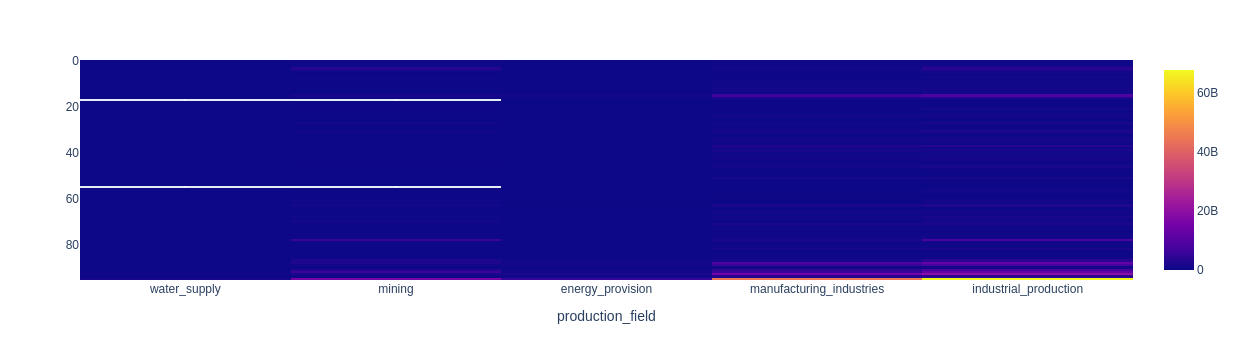

production_field                                             region  \
0                 Архангельская область (кроме Ненецкого автоном...   
1                 Ненецкий автономный округ (Архангельская область)   
2                 Тюменская область (кроме Ханты-Мансийского авт...   
3                 Ханты-Мансийский автономный округ - Югра (Тюме...   
4                 Ямало-Ненецкий автономный округ (Тюменская обл...   
..                                                              ...   
91                                      Сибирский федеральный округ   
92                                      Уральский федеральный округ   
93                                    Центральный федеральный округ   
94                           Южный федеральный округ (с 29.07.2016)   
95                                             Российская Федерация   

production_field  water_supply         mining  energy_provision  \
0                   5585370.30    31165007.90       33846746.81   
1                    527223.19   308749444.07        3981916.75   
2                  13002333.93   218648828.27       53001253.01   
3                  23989538.15  3320220987.45      220242182.80   
4                  11384815.62  2351223033.22       53939251.00   
..                         ...            ...               ...   
91                133285359.99  2494776547.65      651774622.14   
92                162878721.11  6068785435.93      722310584.86   
93                395285096.22  1787162125.55     1784581358.07   
94                102409515.94   441536158.85      424730470.97   
95               1240288414.85 16233265285.42     5696757679.32   

production_field  manufacturing_industries  industrial_production  
0                             243549475.00           314146600.00  
1                               9904088.05           323162672.06  
2                             701439790.75           986092205.97  
3                             618836550.89          4183289259.29  
4                             368252669.38          2784799769.23  
..                                     ...                    ...  
91                           4546361541.93          7826198071.86  
92                           5191478328.01         12145453069.90  
93                          15571450691.93         19538479271.75  
94                           2856968863.16          3825645008.89  
95                          44632637312.48         67802948692.14  

[96 rows x 6 columns]

In [37]:
pivot_prod_2 = pd.pivot_table(
    regional_production_2,
    index = 'region',
    columns = 'production_field',
    aggfunc = 'mean'
)

pivot_prod_2 = pivot_prod_2.loc[:, ('regional_production')]
pivot_prod_2.reset_index(inplace=True)
pivot_prod_2.dropna(axis=1, thresh=pivot_prod_2.shape[0] * 0.7, inplace=True)
pivot_prod_2.rename(columns={'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ':'water_supply', 'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ':'mining', 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА':'energy_provision', 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА':'manufacturing_industries', 'Промышленное производство (промышленность)':'industrial_production'}, inplace=True)
pivot_prod_2['region'] = pivot_prod_2['region'].apply(lambda arg: ' '.join(arg.split()))

fig = px.imshow(pivot_prod_2.iloc[:, 1:])
fig.show()
pivot_prod_2


In [38]:
merged_df = merged_df.merge(pivot_prod_2, how='left', on='region')
merged_df.shape

(85, 47)

In [39]:
retail_turnover = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xls', header=2)
retail_turnover.drop(0, axis=0, inplace=True)
retail_turnover.drop('Unnamed: 1', axis=1, inplace=True)
retail_turnover.rename(columns={'Unnamed: 0':'region'}, inplace=True)

retail_turnover

region   2000   2001   2002   2003   2004  \
1                    Российская Федерация  16046  21031  25913  31557  39166   
2           Центральный федеральный округ  26062  33630  40010  46760  57011   
3                    Белгородская область  11820  13837  16366  19222  24168   
4                        Брянская область   8267  10951  14312  17988  22849   
5                    Владимирская область   7442   9403  10984  13357  16584   
..                                    ...    ...    ...    ...    ...    ...   
104                   Магаданская область  14806  19700  24101  29511  33831   
105                   Сахалинская область  14152  21250  28378  35556  45754   
106          Еврейская автономная область   9198  13088  18310  23575  31193   
107            Чукотский автономный округ  13723  22132  32979  38253  41111   
108            Крымский федеральный округ    NaN    NaN    NaN    NaN    NaN   

      2005   2006   2007    2008  ...    2012    2013    2014    2015    2016  \
1    49063  60901  76111   97688  ...  149401  165051  180410  188017  192541   
2    68302  81774  97965  121934  ...  188757  207394  231873  237737  243426   
3    30174  41387  55460   74599  ...  129904  144992  164079  178097  192504   
4    28892  36931  48448   64977  ...  121136  138669  158501  177048  179767   
5    21140  29719  42497   56943  ...  103848  116202  129564  139408  143643   
..     ...    ...    ...     ...  ...     ...     ...     ...     ...     ...   
104  40935  49440  59698   70108  ...  126320  153398  174694  187765  202541   
105  59836  82315  98458  134570  ...  209149  228920  250253  272527  276476   
106  39171  45012  51274   63606  ...   98243  108408  117276  133748  134162   
107  41405  45132  52030   81808  ...  113267  108218  102795  119335  154019   
108    NaN    NaN    NaN     NaN  ...     NaN     NaN   80958  109640       0   

       2017    2018    2019    2020    2021  
1    202568  215074  229104  231283  270606  
2    258278  277011  296368  301192  354141  
3    203298  217059  230704  237076  259151  
4    192775  209987  225818  225643  257679  
5    153088  164519  175251  177680  207670  
..      ...     ...     ...     ...     ...  
104  213558  226312  240162  245817  289171  
105  289573  303112  327601  338787  364356  
106  138444  149572  165356  168066  188492  
107  183781  193391  209839  217089  225671  
108     NaN     NaN     NaN     NaN     NaN  

[108 rows x 23 columns]

In [40]:
for col in retail_turnover.columns:
    retail_turnover[col] = retail_turnover[col].apply(lambda x: float('nan') if x == 0 else x)
    
retail_turnover['retail_turnover'] = [retail_turnover.iloc[i, -8:].mean() for i in range(retail_turnover.shape[0])]
retail_turnover = retail_turnover.loc[:, ['region', 'retail_turnover']]
retail_turnover.loc[:, 'region'] = retail_turnover.loc[:, 'region'].apply(lambda arg: ' '.join(arg.split()))
retail_turnover

region  retail_turnover
1             Российская Федерация        213700.38
2    Центральный федеральный округ        275003.25
3             Белгородская область        210246.00
4                 Брянская область        203402.25
5             Владимирская область        161352.88
..                             ...              ...
104            Магаданская область        222502.50
105            Сахалинская область        302835.62
106   Еврейская автономная область        149389.50
107     Чукотский автономный округ        175740.00
108     Крымский федеральный округ         95299.00

[108 rows x 2 columns]

In [54]:
print(set(merged_df['region'].values).difference(retail_turnover['region'].values))
print(set(retail_turnover['region'].values).difference(merged_df['region'].values))

set()
{'Архангельская область (без АО)', 'Северо-Кавказский федеральный округ', 'Усть-Ордынский Бурятский округ', 'Корякский округ, входящий в состав Камчатского края', 'Эвенкийский автономный округ (Красноярский край)', 'Приволжский федеральный округ', 'Центральный федеральный округ', 'Северо-Западный федеральный округ', 'Южный федеральный округ (с 2010 года)', 'Крымский федеральный округ', 'Коми-Пермяцкий округ, входящий в состав Пермского края', 'Сибирский федеральный округ', 'Уральский федеральный округ', 'Тюменская область (без АО)', 'Агинский Бурятский округ (Забайкальский край)', 'Архангельская область', 'Российская Федерация', 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)', 'Южный федеральный округ (с 29.07.2016)', 'Тюменская область', 'Дальневосточный федеральный округ'}


In [41]:
retail_turnover.loc[retail_turnover['region'] == 'Архангельская область (без АО)', 'region'] = 'Архангельская область без автономного округа'
retail_turnover.loc[retail_turnover['region'] == 'Тюменская область (без АО)', 'region'] = 'Тюменская область без автономных округов'

In [42]:
merged_df = merged_df.merge(retail_turnover, how='left', on='region')
merged_df.shape

(85, 48)

In [43]:
welfare = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')

welfare.dropna(axis=0, thresh=welfare.shape[1]*0.2, inplace=True)
welfare['region'] = welfare['region'].apply(lambda x: ' '.join(x.split()))

welfare['welfare_mean'] = [round(welfare.iloc[i, 1:].mean()) for i in range(welfare.shape[0])]
welfare = welfare[['region', 'welfare_mean']]
welfare

region  welfare_mean
0           Российская Федерация            19
2           Белгородская область            14
3               Брянская область            23
4           Владимирская область            22
5            Воронежская область            19
..                           ...           ...
89              Амурская область            24
90           Магаданская область            12
91           Сахалинская область            13
92  Еврейская автономная область            25
93    Чукотский автономный округ             7

[86 rows x 2 columns]

In [69]:
print(set(merged_df['region'].values).difference(welfare['region'].values))
print(set(welfare['region'].values).difference(merged_df['region'].values))

{'Республика Татарстан (Татарстан)', 'Архангельская область (кроме Ненецкого автономного округа)', 'Город Санкт-Петербург город федерального значения', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Город федерального значения Севастополь', 'Ханты-Мансийский автономный округ - Югра (Тюменская область)', 'Ненецкий автономный округ (Архангельская область)', 'Ямало-Ненецкий автономный округ (Тюменская область)', 'Кемеровская область - Кузбасс', 'Чувашская Республика - Чувашия', 'Город Москва столица Российской Федерации город федерального значения', 'Республика Адыгея (Адыгея)'}
{'Ямало-Ненецкий автономный округ', 'Ханты-Мансийский автономный округ - Югра', 'г. Москва', 'Республика Адыгея', 'Ненецкий автономный округ', 'г. Санкт-Петербург', 'Российская Федерация', 'Кемеровская область', 'г. Севастополь', 'Республика Татарстан', 'Чувашская Республика'}


In [44]:
welfare.loc[welfare['region'] == 'Ханты-Мансийский автономный округ - Югра', 'region'] = 'Ханты-Мансийский автономный округ - Югра (Тюменская область)'
welfare.loc[welfare['region'] == 'Ямало-Ненецкий автономный округ', 'region'] = 'Ямало-Ненецкий автономный округ (Тюменская область)'
welfare.loc[welfare['region'] == 'Чувашская Республика', 'region'] = 'Чувашская Республика - Чувашия'
welfare.loc[welfare['region'] == 'Республика Адыгея', 'region'] = 'Республика Адыгея (Адыгея)'
welfare.loc[welfare['region'] == 'г. Москва', 'region'] = 'Город Москва столица Российской Федерации город федерального значения'
welfare.loc[welfare['region'] == 'г. Севастополь', 'region'] = 'Город федерального значения Севастополь'
welfare.loc[welfare['region'] == 'Республика Татарстан', 'region'] = 'Республика Татарстан (Татарстан)'
welfare.loc[welfare['region'] == 'Ненецкий автономный округ', 'region'] = 'Ненецкий автономный округ (Архангельская область)'
welfare.loc[welfare['region'] == 'Кемеровская область', 'region'] = 'Кемеровская область - Кузбасс'
welfare.loc[welfare['region'] == 'г. Санкт-Петербург', 'region'] = 'Город Санкт-Петербург город федерального значения'

In [45]:
merged_df = merged_df.merge(welfare, how='left', on='region')
merged_df.shape

(85, 49)

In [46]:
df = pd.read_excel('data/morbidity_2005_2020_age_disease.xls', header=2)
df.rename(columns={'Unnamed: 0':'region', 'Unnamed: 1':'disease', 'Unnamed: 2':'age'}, inplace=True)
df['region'] = df['region'].apply(lambda x: ' '.join(x.split()))
df['morbidity'] = [df.iloc[i, 3:].mean() for i in range(df.shape[0])]
df = df.loc[:, ['region', 'disease', 'age', 'morbidity']]
df

region  \
0           Российская Федерация   
1           Российская Федерация   
2           Российская Федерация   
3           Российская Федерация   
4           Российская Федерация   
...                          ...   
8154  Крымский федеральный округ   
8155  Крымский федеральный округ   
8156  Крымский федеральный округ   
8157  Крымский федеральный округ   
8158  Крымский федеральный округ   

                                                disease              age  \
0              Беременность, роды и послеродовой период         0-14 лет   
1              Беременность, роды и послеродовой период        15-17 лет   
2              Беременность, роды и послеродовой период  18 лет и старше   
3              Беременность, роды и послеродовой период            Всего   
4             Болезни глаза и его придаточного аппарата         0-14 лет   
...                                                 ...              ...   
8154  Психические расстройства и расстройства поведения            Всего   
8155  Травмы, отравления и другие последствия воздей...         0-14 лет   
8156  Травмы, отравления и другие последствия воздей...        15-17 лет   
8157  Травмы, отравления и другие последствия воздей...  18 лет и старше   
8158  Травмы, отравления и другие последствия воздей...            Всего   

      morbidity  
0         16.47  
1       1338.77  
2       7653.69  
3       6649.85  
4       5869.51  
...         ...  
8154     421.90  
8155    5100.40  
8156   10408.10  
8157    3904.80  
8158    4674.05  

[8159 rows x 4 columns]

In [47]:
pivot = pd.pivot_table(
    df,
    values='morbidity',
    columns = 'disease',
    index='region',
    aggfunc='sum'
)

pivot.reset_index(inplace=True)
pivot

disease                                             region  \
0                                           Алтайский край   
1                                         Амурская область   
2        Архангельская обл. без данных по Ненецкому авт...   
3                                    Архангельская область   
4                                     Астраханская область   
..                                                     ...   
97       Ямало-Ненецкий автономный округ (Тюменская обл...   
98                                     Ярославская область   
99                                               г. Москва   
100                                     г. Санкт-Петербург   
101                                         г. Севастополь   

disease  Беременность, роды и послеродовой период  \
0                                        30359.53   
1                                        15289.41   
2                                        26757.73   
3                                        24334.64   
4                                        25800.71   
..                                            ...   
97                                       24966.46   
98                                       12854.01   
99                                       13138.79   
100                                      13959.85   
101                                      22628.90   

disease  Болезни глаза и его придаточного аппарата  \
0                                         23152.05   
1                                         16743.30   
2                                         24350.80   
3                                         23454.67   
4                                         35231.38   
..                                             ...   
97                                        27567.78   
98                                        20213.84   
99                                        17004.32   
100                                       18574.18   
101                                       13019.97   

disease  Болезни костно-мышечной системы и соединительной ткани  \
0                                                 22918.05        
1                                                 14918.01        
2                                                 24147.70        
3                                                 23052.06        
4                                                 24176.98        
..                                                     ...        
97                                                22251.40        
98                                                18405.89        
99                                                16457.62        
100                                               17249.77        
101                                               10065.23        

disease  Болезни мочеполовой системы  Болезни нервной системы  \
0                           38707.90                 12800.42   
1                           19558.27                  9857.79   
2                           26753.23                 11249.43   
3                           26526.62                  8844.40   
4                           35626.33                 20873.12   
..                               ...                      ...   
97                          29534.01                 15260.60   
98                          19963.31                  6848.07   
99                          15382.03                  7151.91   
100                         22492.38                 12589.20   
101                          7032.03                  8058.17   

disease  Болезни органов дыхания  Болезни органов пищеварения  \
0                      242160.46                     33311.10   
1                      215469.31                     24647.23   
2                      325536.00                     34048.77   
3                      315177.32                     33327.53   
4                      372140.52                     30635

In [66]:
print(set(merged_df['region'].values).difference(pivot['region'].values))
print(set(pivot['region'].values).difference(merged_df['region'].values))

{'Город Санкт-Петербург город федерального значения', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Архангельская область (кроме Ненецкого автономного округа)', 'Кемеровская область - Кузбасс', 'Город Москва столица Российской Федерации город федерального значения', 'Город федерального значения Севастополь'}
{'Дальневосточный федеральный округ', 'Северо-Кавказский федеральный округ (с 03.06.2014)', 'Приволжский федеральный округ', 'г. Санкт-Петербург', 'г. Севастополь', 'Российская Федерация', 'Уральский федеральный округ', 'Республика Северная Осетия - Алания', 'Республика Адыгея (Адыгея) (до 03.06.2014)', 'Тюменская обл.без данных по Ханты-Мансийскому и Ямало-Ненецкому авт. окр.', 'Сибирский федеральный округ', 'Архангельская обл. без данных по Ненецкому авт. окр.', 'Северо-Западный федеральный округ', 'Кемеровская область', 'Южный федеральный округ (с 03.06.2014)', 'Южный федеральный округ (с 28.07.2016)', 'Крымский феде

In [48]:
pivot.loc[pivot['region'] == 'Архангельская обл. без данных по Ненецкому авт. окр.', 'region'] = 'Архангельская область (кроме Ненецкого автономного округа)'
pivot.loc[pivot['region'] == 'Тюменская обл.без данных по Ханты-Мансийскому и Ямало-Ненецкому авт. окр.', 'region'] = 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'
pivot.loc[pivot['region'] == 'г. Москва', 'region'] = 'Город Москва столица Российской Федерации город федерального значения'
pivot.loc[pivot['region'] == 'г. Севастополь', 'region'] = 'Город федерального значения Севастополь'
pivot.loc[pivot['region'] == 'Кемеровская область', 'region'] = 'Кемеровская область - Кузбасс'
pivot.loc[pivot['region'] == 'г. Санкт-Петербург', 'region'] = 'Город Санкт-Петербург город федерального значения'

In [49]:
merged_df = merged_df.merge(pivot, how='left', on='region')
merged_df.shape

(85, 68)

In [50]:
migr_1 = pd.read_excel('data/BulMigr-2021.xlsx', sheet_name='1.1 ')
migr_1.dropna(inplace=True)
migr_1.rename(columns={'Содержание':'region', 'Unnamed: 1':'area', 'Unnamed: 6': 'population_density'}, inplace=True)
migr_1 = migr_1.loc[:, ['region', 'area', 'population_density']]
migr_1['region'] = migr_1['region'].apply(lambda x: ' '.join(x.split()))
migr_1


region   area population_density
12           Белгородская область  27.10              56.50
13               Брянская область  34.90              33.50
14           Владимирская область  29.10              45.50
15            Воронежская область  52.20              43.80
16             Ивановская область  21.40              45.60
..                            ...    ...                ...
101              Амурская область 361.90               2.10
102           Магаданская область 462.50               0.30
103           Сахалинская область  87.10               5.60
104  Еврейская автономная область  36.30               4.20
105    Чукотский автономный округ 721.50               0.10

[85 rows x 3 columns]

In [51]:
migr_2 = pd.read_excel('data/BulMigr-2021.xlsx', sheet_name='1.3_Всего')
migr_2 = migr_2.iloc[:, :8]
migr_2.dropna(inplace=True)
migr_2.rename(columns={'Содержание':'region', 'Unnamed: 2': 'population_general_growth', 'Unnamed: 3': 'population_natural_growth', 'Unnamed: 4':'population_migration_growth'}, inplace=True)
migr_2 = migr_2.loc[:, ['region', 'population_general_growth', 'population_natural_growth', 'population_migration_growth']]
migr_2['region'] = migr_2['region'].apply(lambda x: ' '.join(x.split()))
migr_2

region population_general_growth  \
8             Российская Федеpация                   -613439   
9    Центральный федеральный округ                   -146560   
10            Белгородская область                     -9342   
11                Брянская область                    -13911   
12            Владимирская область                    -18440   
..                             ...                       ...   
99                Амурская область                     -9321   
100            Магаданская область                     -1267   
101            Сахалинская область                     -1444   
102   Еврейская автономная область                     -2669   
103     Чукотский автономный округ                       513   

    population_natural_growth population_migration_growth  
8                    -1043341                      429902  
9                     -337331                      190771  
10                     -15778                        6436  
11                     -14816                         905  
12                     -18914                         474  
..                        ...                         ...  
99                      -6977                       -2344  
100                      -877                        -390  
101                     -2149                         705  
102                     -1259                       -1410  
103                       -38                         551  

[96 rows x 4 columns]

In [67]:
print(set(migr_1['region'].values).difference(migr_2['region'].values))
print(set(migr_2['region'].values).difference(migr_1['region'].values))

{'Ханты-Мансийский автономный округ'}
{'Сибирский федеральный округ', 'Ханты-Мансийский автономный округ-Югра', 'Северо-Кавказский федеральный округ', 'Российская Федеpация', 'Уральский федеральный округ', 'Архангельская область', 'Южный федеральный округ', 'Приволжский федеральный округ', 'Центральный федеральный округ', 'Северо-Западный федеральный округ', 'Тюменская область', 'Дальневосточный федеральный округ'}


In [52]:
migr_2.loc[migr_2['region'] == 'Ханты-Мансийский автономный округ-Югра', 'region'] = 'Ханты-Мансийский автономный округ'

In [53]:
migr_3 = pd.read_excel('data/BulMigr-2021.xlsx', sheet_name='1.5')
migr_3.dropna(inplace=True)
migr_3.rename(columns={'Содержание':'region', 'Unnamed: 2':'urban_population_share', 'Unnamed: 4':'rural_per_1000_city'}, inplace=True)
migr_3 = migr_3.loc[:, ['region', 'urban_population_share', 'rural_per_1000_city']]
migr_3['region'] = migr_3['region'].apply(lambda x: ' '.join(x.split()))
migr_3

region urban_population_share rural_per_1000_city
8    Центральный федеральный округ                  17.60               26.87
9             Белгородская область                  32.28                1.05
10                Брянская область                  29.41                0.80
11            Владимирская область                  21.83                0.91
12             Воронежская область                  31.89                1.57
..                             ...                    ...                 ...
98                Амурская область                  31.95                0.53
99             Магаданская область                   3.86                0.09
100            Сахалинская область                  17.30                0.33
101   Еврейская автономная область                  31.88                0.11
102     Чукотский автономный округ                  28.06                0.03

[95 rows x 3 columns]

In [70]:
print(set(migr_1['region'].values).difference(migr_3['region'].values))
print(set(migr_3['region'].values).difference(migr_1['region'].values))

{'Ханты-Мансийский автономный округ'}
{'Сибирский федеральный округ', 'Ханты-Мансийский автономный округ-Югра', 'Северо-Кавказский федеральный округ', 'Уральский федеральный округ', 'Архангельская область', 'Южный федеральный округ', 'Приволжский федеральный округ', 'Центральный федеральный округ', 'Северо-Западный федеральный округ', 'Тюменская область', 'Дальневосточный федеральный округ'}


In [54]:
migr_3.loc[migr_3['region'] == 'Ханты-Мансийский автономный округ-Югра', 'region'] = 'Ханты-Мансийский автономный округ'

In [55]:
migr_4 = pd.read_excel('data/BulMigr-2021.xlsx', sheet_name='2.2_Приб')
migr_4.dropna(inplace=True)
migr_4.rename(columns={'Содержание':'region', 'Unnamed: 1':'migration_in'}, inplace=True)
migr_4 = migr_4.loc[:, ['region', 'migration_in']]
migr_4['region'] = migr_4['region'].apply(lambda x: ' '.join(x.split()))
migr_4

region migration_in
6             Российская Федерация      4277442
7    Центральный федеральный округ      1128332
8             Белгородская область        46566
9                 Брянская область        31287
10            Владимирская область        30695
..                             ...          ...
97                Амурская область        22027
98             Магаданская область         6735
99             Сахалинская область        17515
100   Еврейская автономная область         3536
101     Чукотский автономный округ         5336

[96 rows x 2 columns]

In [103]:
print(set(migr_1['region'].values).difference(migr_4['region'].values))
print(set(migr_4['region'].values).difference(migr_1['region'].values))

set()
{'Уральский федеральный округ', 'Северо-Кавказский федеральный округ', 'Сибирский федеральный округ', 'Центральный федеральный округ', 'Дальневосточный федеральный округ', 'Южный федеральный округ', 'Тюменская область', 'Архангельская область', 'Российская Федерация', 'Приволжский федеральный округ', 'Северо-Западный федеральный округ'}


In [56]:
migr_4.loc[migr_4['region'] == 'Ханты-Мансийский автономный округ-Югра', 'region'] = 'Ханты-Мансийский автономный округ'
migr_4.loc[migr_4['region'] == 'г.Севастополь', 'region'] = 'г. Севастополь'
migr_4.loc[migr_4['region'] == 'Республика Северная Осетия - Алания', 'region'] = 'Республика Северная Осетия-Алания'
migr_4.loc[migr_4['region'] == 'Архангельская область без автономного округа', 'region'] = 'Архангельская область без Ненецкого автономного округа'
migr_4.loc[migr_4['region'] == 'г.Москва', 'region'] = 'г. Москва'

In [57]:
migr_5 = pd.read_excel('data/BulMigr-2021.xlsx', sheet_name='2.2_Выб')
migr_5 = migr_5.iloc[:, :9]
migr_5.dropna(inplace=True)
migr_5.rename(columns={'Содержание':'region', 'Unnamed: 1':'migration_out'}, inplace=True)
migr_5 = migr_5.loc[:,['region', 'migration_out']]
migr_5['region'] = migr_5['region'].apply(lambda x: ' '.join(x.split()))
migr_5

region migration_out
4            Российская Федерация       3847540
5   Центральный федеральный округ        937561
6            Белгородская область         40130
7                Брянская область         30382
8            Владимирская область         30221
..                            ...           ...
95               Амурская область         24371
96            Магаданская область          7125
97            Сахалинская область         16810
98   Еврейская автономная область          4946
99     Чукотский автономный округ          4785

[96 rows x 2 columns]

In [107]:
print(set(migr_1['region'].values).difference(migr_5['region'].values))
print(set(migr_5['region'].values).difference(migr_1['region'].values))

set()
{'Уральский федеральный округ', 'Северо-Кавказский федеральный округ', 'Сибирский федеральный округ', 'Центральный федеральный округ', 'Дальневосточный федеральный округ', 'Южный федеральный округ', 'Тюменская область', 'Архангельская область', 'Российская Федерация', 'Приволжский федеральный округ', 'Северо-Западный федеральный округ'}


In [58]:
migr_5.loc[migr_5['region'] == 'Ханты-Мансийский автономный округ-Югра', 'region'] = 'Ханты-Мансийский автономный округ'
migr_5.loc[migr_5['region'] == 'г.Севастополь', 'region'] = 'г. Севастополь'
migr_5.loc[migr_5['region'] == 'Республика Северная Осетия - Алания', 'region'] = 'Республика Северная Осетия-Алания'
migr_5.loc[migr_5['region'] == 'Архангельская область без автономного округа', 'region'] = 'Архангельская область без Ненецкого автономного округа'
migr_5.loc[migr_5['region'] == 'г.Москва', 'region'] = 'г. Москва'

In [59]:
migr_df = migr_1.merge(migr_2, how='left', on ='region')
migr_df = migr_df.merge(migr_3, how='left', on='region')
migr_df = migr_df.merge(migr_4, how='left', on='region')
migr_df = migr_df.merge(migr_5, how='left', on='region')
migr_df

region   area population_density  \
0           Белгородская область  27.10              56.50   
1               Брянская область  34.90              33.50   
2           Владимирская область  29.10              45.50   
3            Воронежская область  52.20              43.80   
4             Ивановская область  21.40              45.60   
..                           ...    ...                ...   
80              Амурская область 361.90               2.10   
81           Магаданская область 462.50               0.30   
82           Сахалинская область  87.10               5.60   
83  Еврейская автономная область  36.30               4.20   
84    Чукотский автономный округ 721.50               0.10   

   population_general_growth population_natural_growth  \
0                      -9342                    -15778   
1                     -13911                    -14816   
2                     -18440                    -18914   
3                     -17930                    -27992   
4                     -10114                    -12794   
..                       ...                       ...   
80                     -9321                     -6977   
81                     -1267                      -877   
82                     -1444                     -2149   
83                     -2669                     -1259   
84                       513                       -38   

   population_migration_growth urban_population_share rural_per_1000_city  \
0                         6436                  32.28                1.05   
1                          905                  29.41                0.80   
2                          474                  21.83                0.91   
3                        10062                  31.89                1.57   
4                         2680                  18.11                0.67   
..                         ...                    ...                 ...   
80                       -2344                  31.95                0.53   
81                        -390                   3.86                0.09   
82                         705                  17.30                0.33   
83                       -1410                  31.88                0.11   
84                         551                  28.06                0.03   

   migration_in migration_out  
0         46566         40130  
1         31287         30382  
2         30695         30221  
3         65639         55577  
4         27887         25207  
..          ...           ...  
80        22027         24371  
81         6735          7125  
82        17515         16810  
83         3536          4946  
84         5336          4785  

[85 rows x 10 columns]

In [146]:
migr_df.isna().sum()

region                         0
area                           0
population_density             0
population_general_growth      0
population_natural_growth      0
population_migration_growth    0
urban_population_share         0
rural_per_1000_city            0
migration_in                   0
migration_out                  0
dtype: int64

In [80]:
print(set(merged_df['region'].values).difference(migr_df['region'].values))
print(set(migr_df['region'].values).difference(merged_df['region'].values))

set()
set()


In [60]:
migr_df.loc[migr_df['region'] == 'Архангельская область без Ненецкого автономного округа', 'region'] = 'Архангельская область (кроме Ненецкого автономного округа)'
migr_df.loc[migr_df['region'] == 'Ямало-Ненецкий автономный округ', 'region'] = 'Ямало-Ненецкий автономный округ (Тюменская область)'
migr_df.loc[migr_df['region'] == 'г. Москва', 'region'] = 'Город Москва столица Российской Федерации город федерального значения'
migr_df.loc[migr_df['region'] == 'г. Севастополь', 'region'] = 'Город федерального значения Севастополь'
migr_df.loc[migr_df['region'] == 'Республика Татарстан', 'region'] = 'Республика Татарстан (Татарстан)'
migr_df.loc[migr_df['region'] == 'г.Санкт-Петербург', 'region'] = 'Город Санкт-Петербург город федерального значения'
migr_df.loc[migr_df['region'] == 'Чувашская Республика', 'region'] = 'Чувашская Республика - Чувашия'
migr_df.loc[migr_df['region'] == 'Ненецкий автономный округ', 'region'] = 'Ненецкий автономный округ (Архангельская область)'
migr_df.loc[migr_df['region'] == 'Республика Адыгея', 'region'] = 'Республика Адыгея (Адыгея)'
migr_df.loc[migr_df['region'] == 'Кемеровская область', 'region'] = 'Кемеровская область - Кузбасс'
migr_df.loc[migr_df['region'] == 'Тюменская область без автономных округов', 'region'] = 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'
migr_df.loc[migr_df['region'] == 'Ханты-Мансийский автономный округ', 'region'] = 'Ханты-Мансийский автономный округ - Югра (Тюменская область)'

In [61]:
merged_df = merged_df.merge(migr_df, how='left', on='region')
merged_df.shape

(85, 77)

Заменим некоторые названия признаков в объеденённом датасете. Сделаем их менее объёмные.

In [62]:
old_col = ['в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности', 'в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность', 'в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность', 'затруднились ответить', 'Размер общей площади в расчете на члена домохозяйства', 'Размер жилой площади в расчете на члена домохозяйства', 'Число жилых комнат в расчете на одно домохозяйство']
new_col = ['all_no_tightness', 'all_some_tightness', 'all_large_tightness', 'all_no_answer', 'total_area_for_person', 'living_area_for_person', 'living_room_count']

for old_name, new_name in zip(old_col, new_col):
    merged_df.rename(columns={old_name:new_name}, inplace=True)

In [63]:
name_col_to_ch = ['из них домохозяйства, собирающиеся улучшить свои жилищные условия', 'из них указавшие: на стесненность проживания', 'из них указавшие: на плохое или очень плохое состояние жилого помещения', 'из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания', 'из числа домохозяйств, собирающихся улучшить свои жилищные условия: планируют вселиться в жилое помещение, строительство которого ведут (участвуют в долевом строительстве)', 'из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются подать документы для постановки на очередь (и/или ожидают прохождения очереди)', 'из числа домохозяйств, собирающихся улучшить свои жилищные условия: рассчитывают на получение нового жилья в связи со сносом дома', 'из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются купить (построить) другое жилье', 'из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются снимать жилье', 'из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются улучшить  свои  жилищные условия  другим способом', 'затруднились ответить', 'домохозяйства, не собирающиеся улучшать свои жилищные условия']
house_condition = ['cond_want_to_improve', 'improve_tightness', 'improve_bad_cond', 'improve_bad_&_tightness_cond', 'improve_are_building', 'improve_going_to_apply_doc', 'improve_renovation', 'improve_going_to_buy_new', 'improve_rent', 'improve_another_way', 'improve_no_answer', 'dont_want_to_improve']

for old_name, new_name in zip(name_col_to_ch, house_condition):
    merged_df.rename(columns={old_name:new_name}, inplace=True)

In [64]:
old_col = ['Дети в возрасте до 16 лет', 'Население старше трудоспособного возраста', 'Население трудоспособного возраста']
new_col = ['poverty_under_sixteen', 'poverty_above_working_age', 'poverty_working_age']
for old_name, new_name in zip(old_col, new_col):
    merged_df.rename(columns={old_name:new_name}, inplace=True)

In [65]:
old_col = ['Беременность, роды и послеродовой период', 'Болезни глаза и его придаточного аппарата', 'Болезни костно-мышечной системы и соединительной ткани', 'Болезни мочеполовой системы', 'Болезни нервной системы', 'Болезни органов дыхания', 'Болезни органов пищеварения', 'Болезни системы кровообращения', 'Болезни уха и сосцевидного отростка', 'Болезни эндокринной системы, расстройства питания и нарушения обмена веществ', 'Врожденные аномалии (пороки развития), деформации и хромосомные нарушения', 'Все заболевания', 'Злокачественные новообразования', 'Некоторые инфекционные и паразитарные болезни', 'Новообразования', 'Отдельные состояния, возникающие в перинатальном периоде', 'Прочие болезни', 'Психические расстройства и расстройства поведения', 'Травмы, отравления и другие последствия воздействия внешних причин']
new_col = ['Pergnancy_period', 'eye_diseases', 'muscul_&_connective_tissue_diseases', 'genitourinary_sys_diseases', 'nervous_sys_diseases', 'respiratory_diseases', 'digestive_sys_diseases', 'circulastory_sys_diseases', 'ear_diseases', 'endocrine_sys_diseases', 'malformations', 'all_diseases', 'malignant_neoplasms', 'infectious', 'neoplasms', 'perinatal_period', 'other_diseases', 'mental_diseases', 'injuries']
for old_name, new_name in zip(old_col, new_col):
    merged_df.rename(columns={old_name:new_name}, inplace=True)

В качестве значений в датасете встречаются строки с тремя точками, символизирующими недостаток информации. Заменим их на значения 'NaN'

In [66]:
object_col = [col for col in merged_df.columns if merged_df[col].dtype == 'object']

for col in object_col:
    merged_df[col] = merged_df[col].apply(lambda x: float('nan') if x == '...' or x == '…*' else x)
    
merged_df.iloc[:, 1:] = merged_df.iloc[:, 1:].astype('float')
merged_df.set_index('region', inplace=True)
merged_df

ch_mort_rural  per_capita_cash_income  \
region                                                                
Белгородская область                  36.53                30692.50   
Брянская область                      37.53                26015.50   
Владимирская область                  26.68                23908.33   
Воронежская область                   39.11                30422.83   
Ивановская область                    14.00                24567.83   
...                                     ...                     ...   
Амурская область                      47.21                30861.50   
Магаданская область                    2.43                58826.83   
Сахалинская область                    8.95                53568.33   
Еврейская автономная область          12.95                24975.50   
Чукотский автономный округ             7.58                75961.83   

                              real_incomes  formal_wage_paid  real_pay  \
region                                                                   
Белгородская область                 99.43          30920.33    102.35   
Брянская область                     98.38          26399.17    100.77   
Владимирская область                 98.15          29127.17    101.70   
Воронежская область                  98.10          30077.00    101.05   
Ивановская область                   97.58          24856.67     99.55   
...                                    ...               ...       ...   
Амурская область                     98.95          41014.33    102.12   
Магаданская область                 100.88          82467.50    102.88   
Сахалинская область                 101.17          75366.83    103.87   
Еврейская автономная область         96.67          37558.17    101.27   
Чукотский автономный округ          101.53          97464.17    102.73   

                              ch_mort_urban     total   18_30    31_40  \
region                                                                   
Белгородская область                  88.03 202033.86 5353.17  9767.11   
Брянская область                      95.94 106031.88 3666.52  6347.06   
Владимирская область                 107.31 123591.75 3894.78  6714.33   
Воронежская область                  142.38 214849.83 6938.16 11816.59   
Ивановская область                    92.25  77695.19 2746.98  4602.31   
...                                     ...       ...     ...      ...   
Амурская область                     104.22  64625.03 3325.66  5248.72   
Магаданская область                   23.44   4995.81  353.98   583.52   
Сахалинская область                   57.19  21395.58 1409.72  2166.09   
Еврейская автономная область          27.22  12550.86  713.66  1186.83   
Чукотский автономный округ             8.31   1612.45  174.78   224.58   

                                41_50  ...  injuries   area  \
region                                 ...                    
Белгородская область         15291.14  ...  43790.90  27.10   
Брянская область              9856.75  ...  41469.16  34.90   
Владимирская область          9472.31  ...  43851.43  29.10   
Воронежская область          17871.23  ...  26161.74  52.20   
Ивановская область            6394.81  ...  47496.93  21.40   
...                               ...  ...       ...    ...   
Амурская область              6287.66  ...  40439.75 361.90   
Магаданская область            687.84  ...  48525.79 462.50   
Сахалинская область           2698.44  ...  33516.30  87.10   
Еврейская автономная область  1316.50  ...  34392.48  36.30   
Чукотский автономный округ     277.00  ...  54553.54 721.50   

                              population_density  population_general_growth  \
region                                                                        
Белгородская область                       56.50                   -9342.00   
Брянская область                           33.50                  -13911.00   
Владимирская область                       4

Визуализируем информацию о признаках с пропусками.

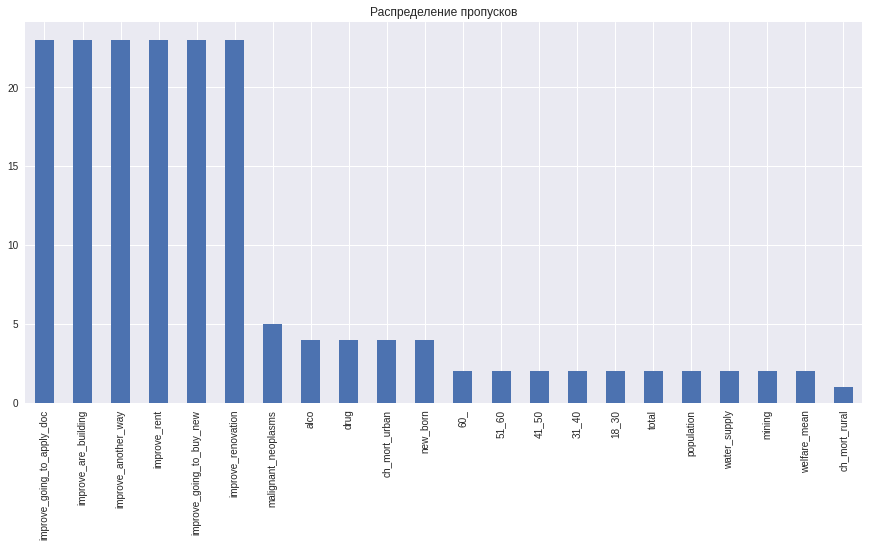

In [67]:
col_with_null_count = merged_df.isnull().sum()
col_with_null = col_with_null_count[col_with_null_count > 0].sort_values(ascending=False) 
col_with_null.plot(kind='bar', figsize=(15,7), title='Распределение пропусков');

Удалим признаки с количеством пропусков больше 20

In [68]:
merged_df.drop(['malignant_neoplasms', 'improve_are_building', 'improve_going_to_apply_doc', 'improve_renovation', 'improve_going_to_buy_new', 'improve_rent', 'improve_another_way', 'improve_bad_cond', 'dont_want_to_improve', 'all_no_tightness'], axis=1, inplace=True)

Попробуем несколько подходов для поиска прпоущенных значений. Для начала вместо пропусков подставим среднее значение. 

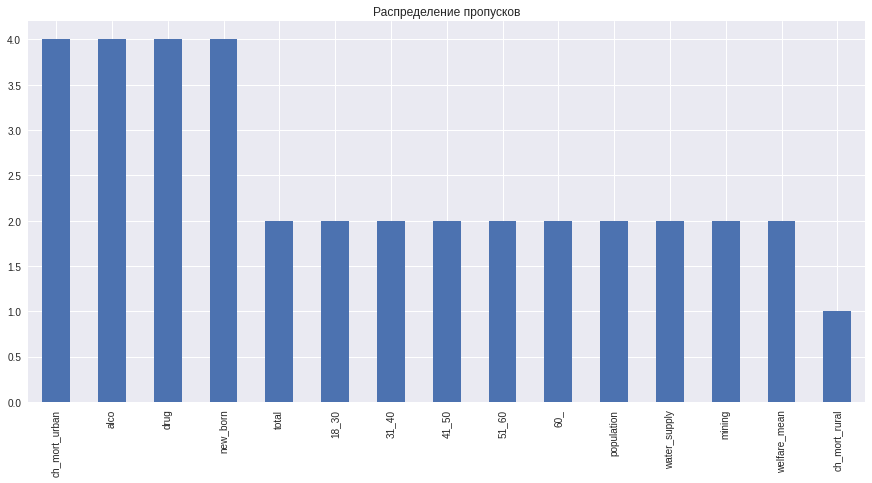

In [69]:
col_with_null_count = merged_df.isnull().sum()
col_with_null = col_with_null_count[col_with_null_count > 0].sort_values(ascending=False) 
col_with_null.plot(kind='bar', figsize=(15,7), title='Распределение пропусков');

К оставшимся с пропусками признаками применим метод fillna и подставим вместо пропусков среднее значение. 

PS В качестве варианта пробовал предсказать пропущенные значения при помощи использвоания различных моделей. В итоге результат их предсказания приводил к более низким оценкам метрики silhouette score. Так же результат демонстрировал большой разброс. Проблему пытался решить путём генерации выборки методом бутстрап. 


In [70]:
values = {
    'ch_mort_urban':merged_df['ch_mort_urban'].mean(),
    'alco':merged_df['alco'].mean(),
    'drug':merged_df['drug'].mean(),
    'new_born':merged_df['new_born'].mean(),
    'total':merged_df['total'].mean(),
    '18_30':merged_df['18_30'].mean(),
    '31_40':merged_df['31_40'].mean(),
    '41_50':merged_df['41_50'].mean(),
    '51_60':merged_df['51_60'].mean(),
    '60_':merged_df['60_'].mean(),
    'population':merged_df['population'].mean(),
    'water_supply':merged_df['water_supply'].mean(),
    'mining':merged_df['mining'].mean(),
    'welfare_mean':merged_df['welfare_mean'].mean(),
    'ch_mort_rural':merged_df['ch_mort_rural'].mean()       
}

merged_df = merged_df.fillna(values)

In [71]:
merged_df['new_born_for_1000'] = 1000 * merged_df['new_born']/merged_df['population']
merged_df['new_born_for_1000'].sort_values()

region
Ленинградская область                                         7.92
Тамбовская область                                            8.21
Республика Мордовия                                           8.26
Смоленская область                                            8.44
Тульская область                                              8.48
                                                              ... 
Республика Дагестан                                          15.95
Республика Ингушетия                                         16.72
Архангельская область (кроме Ненецкого автономного округа)   17.32
Чеченская Республика                                         20.78
Республика Тыва                                              21.00
Name: new_born_for_1000, Length: 85, dtype: float64

In [73]:
merged_df.reset_index(inplace = True)
merged_df.to_csv('data/merged.csv', index=False)

In [173]:
df = pd.read_csv('data/merged.csv')
df.set_index('region', inplace=True)

Так как стоит задача определить какие из регионов наиболее остро нуждаются в помощи малообеспеченным, проанализируем кореляцию всех имеющихся признаков с признаком характеризиующим бедность. Результат визуализируем.

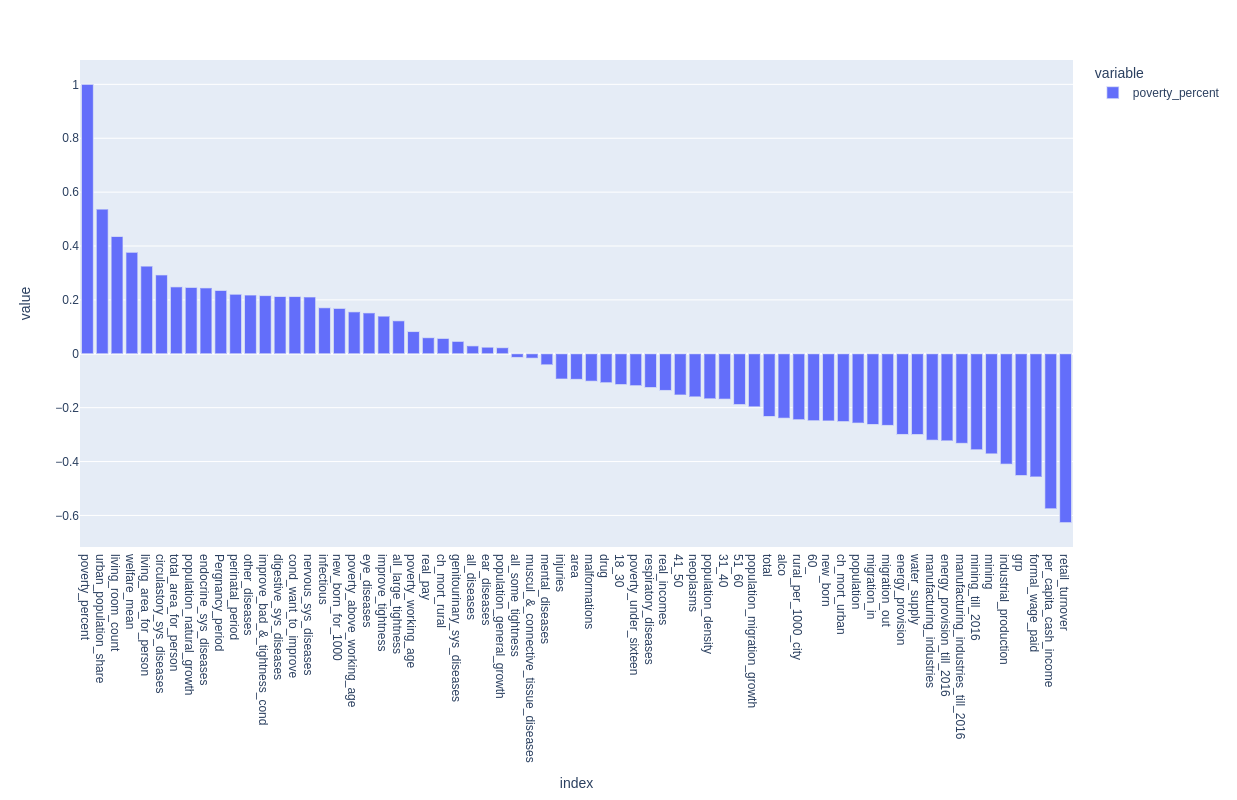

In [174]:
fig = px.bar(df.corr().loc[:, 'poverty_percent'].sort_values(ascending=False), width = 1200, height= 800)
fig.show()

Избавимся от признаков, чей показатель корреляции ниже 0.24

In [175]:
poverty_corr = abs(df.corr().loc[:, 'poverty_percent']).sort_values()

col_to_remove = poverty_corr[poverty_corr < 0.24].index

df.drop(col_to_remove, axis=1, inplace=True)

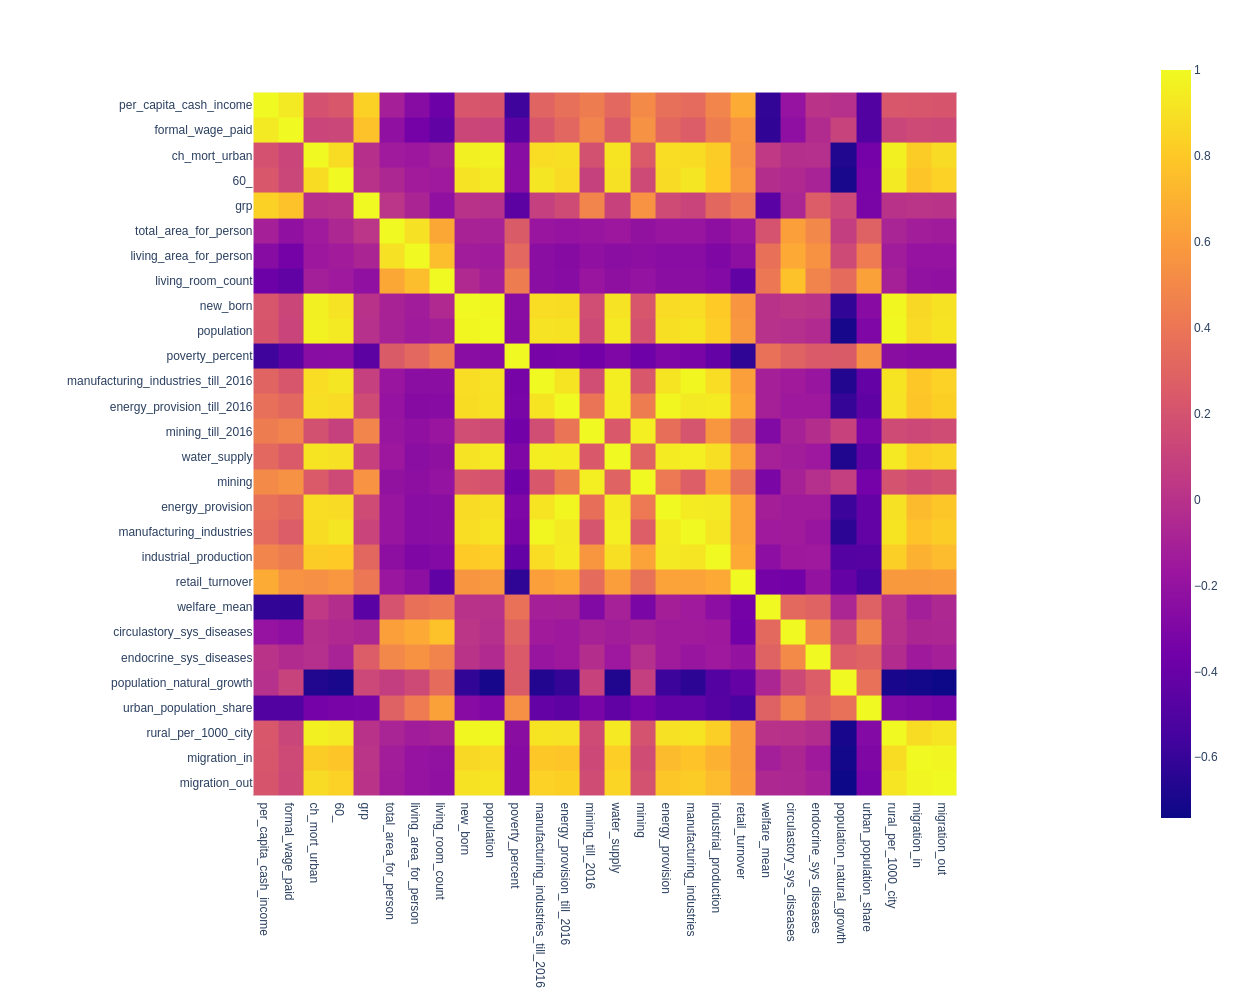

In [87]:
fig = px.imshow(df.corr(), width=1000, height=1000)
fig.show()

Далее попробуем понизить размерность данных с целью визуализации. Понижать размерность будем при помощи алгоритма PCA и TSNE

In [176]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('pca', PCA(n_components=2))])
pipeline.fit(df)

df_processed = pipeline.transform(df)
df_processed = pd.DataFrame(df_processed, columns = ['axis-1', 'axis-2'])
df_processed

axis-1        axis-2
0   182221877.52 -116177110.67
1  -666541143.86 -101503176.96
2  -298837984.95 -189569959.32
3  -213255801.82 -174427118.78
4  -758894820.78  -73256190.67
..           ...           ...
80 -844705849.60   62153459.26
81 -801205858.71   44388614.51
82  -65127085.39  896463961.69
83 -989214594.44  -10198750.56
84 -907985196.09   23766008.73

[85 rows x 2 columns]

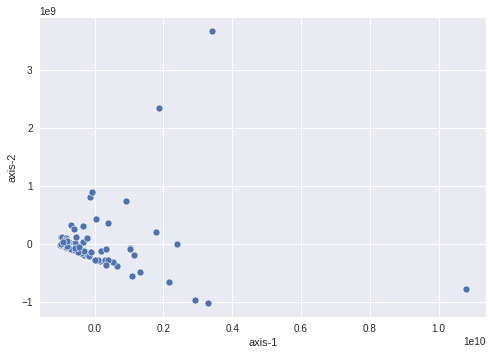

In [177]:
sns.scatterplot(data=df_processed, x='axis-1', y='axis-2');

In [178]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=3, n_iter=3100, random_state=42)

principal_components = tsne.fit_transform(df)

/home/vadym/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/vadym/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



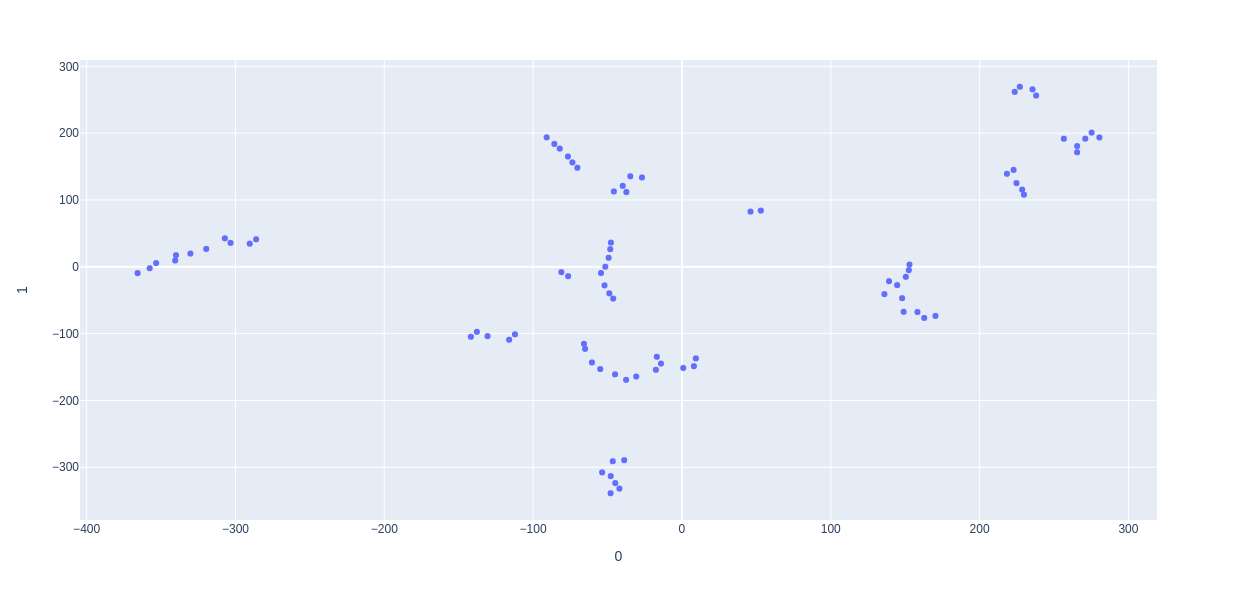

0       1
0   147.91  -46.99
1   -53.63 -307.68
2  -112.23 -101.08
3  -130.64 -103.81
4   235.53  265.51
..     ...     ...
80  228.61  115.56
81  224.76  125.17
82  -81.05   -8.07
83 -303.30   35.78
84 -365.76   -9.48

[85 rows x 2 columns]

In [179]:
tsne_df = pd.DataFrame(principal_components)
fig = px.scatter(tsne_df, x=0, y=1, width=600, height=600)
fig.show()
tsne_df

В результате нелинейного понижения размерности при помощи алгоритма TSNE удаётся довольно чётко увидеть предпологаемые будущие кластеры. Далее попробуем построить модель кастеризации при помощи различных алгоритмов. А так определим какой алгоритм позволяет достигнуть наиболее высокого показателя метрики silhouette score.

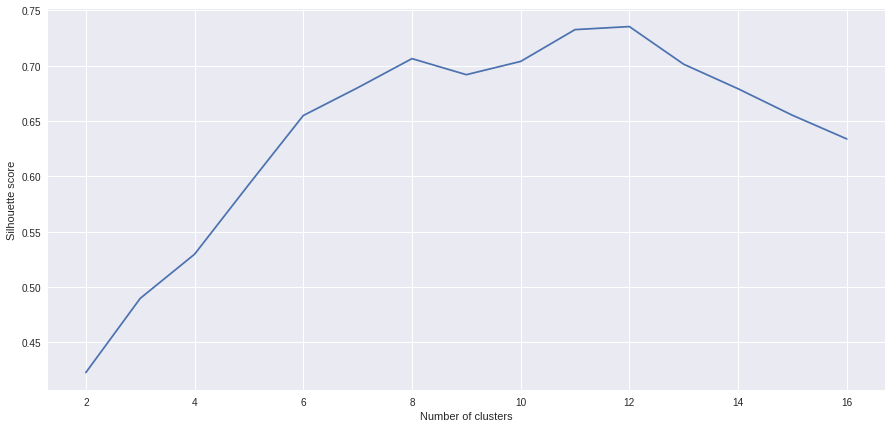

In [180]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def get_silhouette(num_clusters, X):
    model = AgglomerativeClustering(n_clusters = num_clusters)
    
    model.fit(X)
    
    silhouette = silhouette_score(X, model.labels_)
    
    return silhouette 


silhouette_scores = [] 
for i in range(2, 17):
    silhouette_scores.append(get_silhouette(i, tsne_df))
    
fig = plt.figure(figsize=(15,7))

lineplot = sns.lineplot(x = [arg for arg in range(2,17)],y = silhouette_scores)

lineplot.set_ylabel('Silhouette score')
lineplot.set_xlabel('Number of clusters');

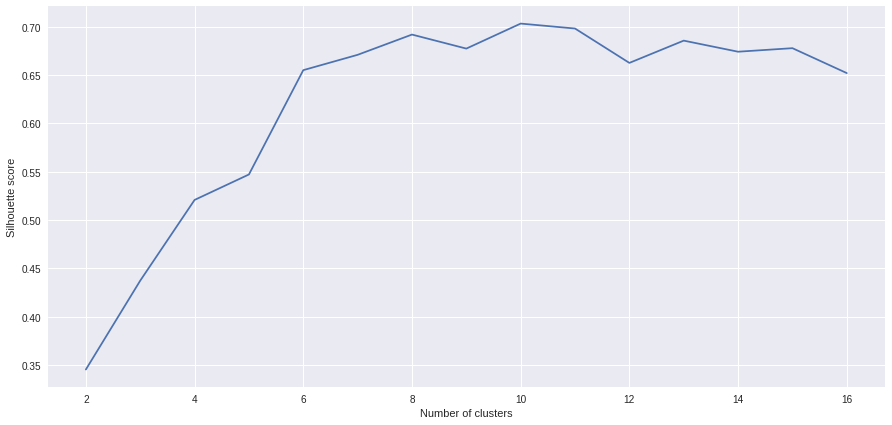

In [181]:
def get_silhouette(num_clusters, X):
    model = GaussianMixture(n_components=num_clusters, random_state=42)
    
    model.fit(X)
    
    silhouette = silhouette_score(X, model.predict(X))
    
    return silhouette 


silhouette_scores = [] 
for i in range(2, 17):
    silhouette_scores.append(get_silhouette(i, tsne_df))
    
fig = plt.figure(figsize=(15,7))

lineplot = sns.lineplot(x = [arg for arg in range(2,17)],y = silhouette_scores)

lineplot.set_ylabel('Silhouette score')
lineplot.set_xlabel('Number of clusters');

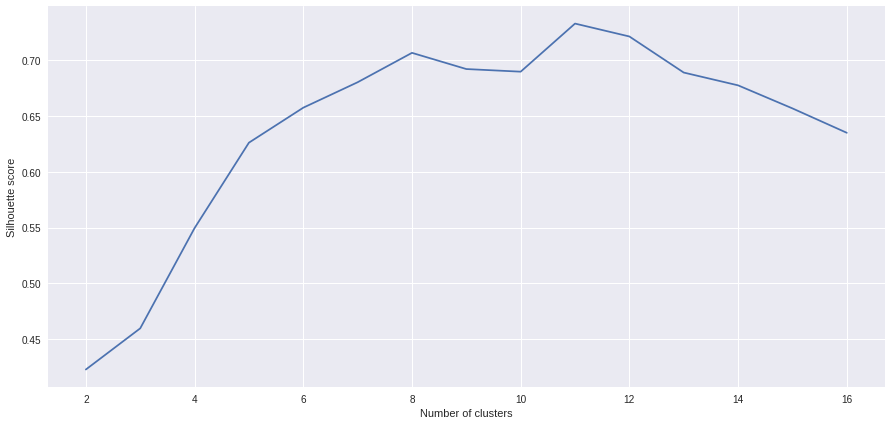

In [182]:
def get_silhouette(num_clusters, X):
    model = KMeans(n_clusters=num_clusters,  random_state=42)
    
    model.fit(X)
    
    silhouette = silhouette_score(X, model.labels_)
    
    return silhouette 


silhouette_scores = [] 
for i in range(2, 17):
    silhouette_scores.append(get_silhouette(i, tsne_df))
    
fig = plt.figure(figsize=(15,7))

lineplot = sns.lineplot(x = [arg for arg in range(2,17)],y = silhouette_scores)

lineplot.set_ylabel('Silhouette score')
lineplot.set_xlabel('Number of clusters');

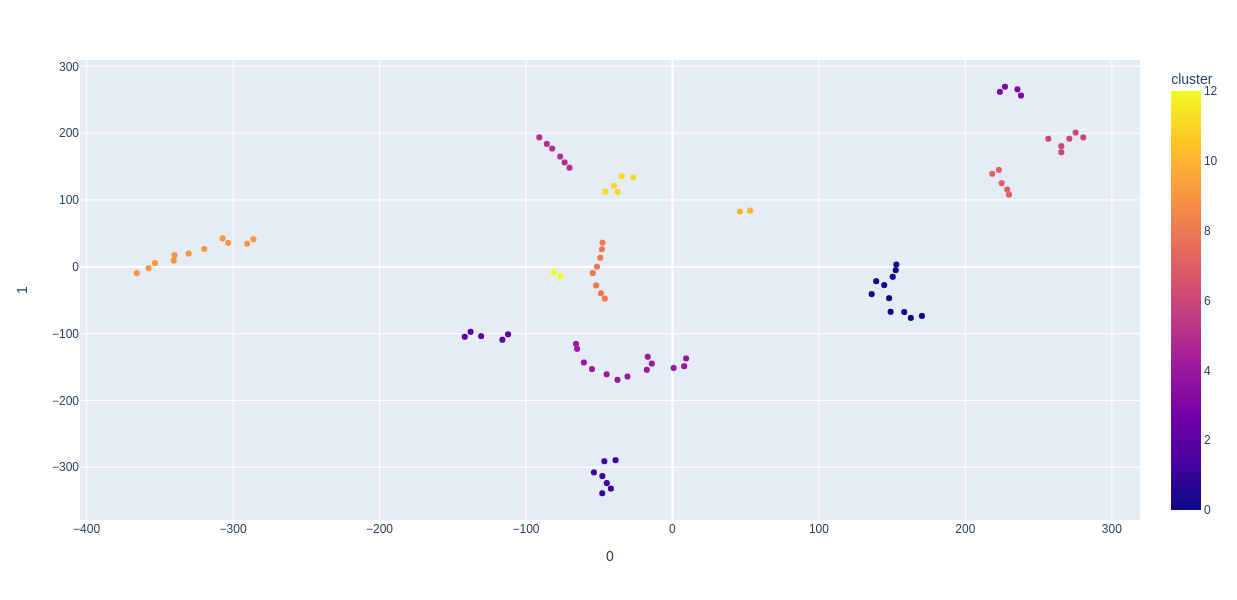

0       1  cluster
region                                               
Белгородская область          147.91  -46.99        0
Брянская область              -53.63 -307.68        1
Владимирская область         -112.23 -101.08        2
Воронежская область          -130.64 -103.81        2
Ивановская область            235.53  265.51        3
...                              ...     ...      ...
Амурская область              228.61  115.56        7
Магаданская область           224.76  125.17        7
Сахалинская область           -81.05   -8.07       12
Еврейская автономная область -303.30   35.78        9
Чукотский автономный округ   -365.76   -9.48        9

[85 rows x 3 columns]

Silhouette score: 0.6832937598228455


In [183]:
db_scan = DBSCAN(eps = 22, min_samples = 1)
db_clustering = db_scan.fit(principal_components)
db_labels = db_clustering.labels_

df_db_labeled = pd.DataFrame(principal_components, index=df.index)
df_db_labeled['cluster'] = db_labels

fig = px.scatter(df_db_labeled, x = 0, y = 1, color='cluster', height = 600 , width=600)
fig.show()

display(df_db_labeled)
print(f'Silhouette score: {silhouette_score(tsne_df, db_labels)}')

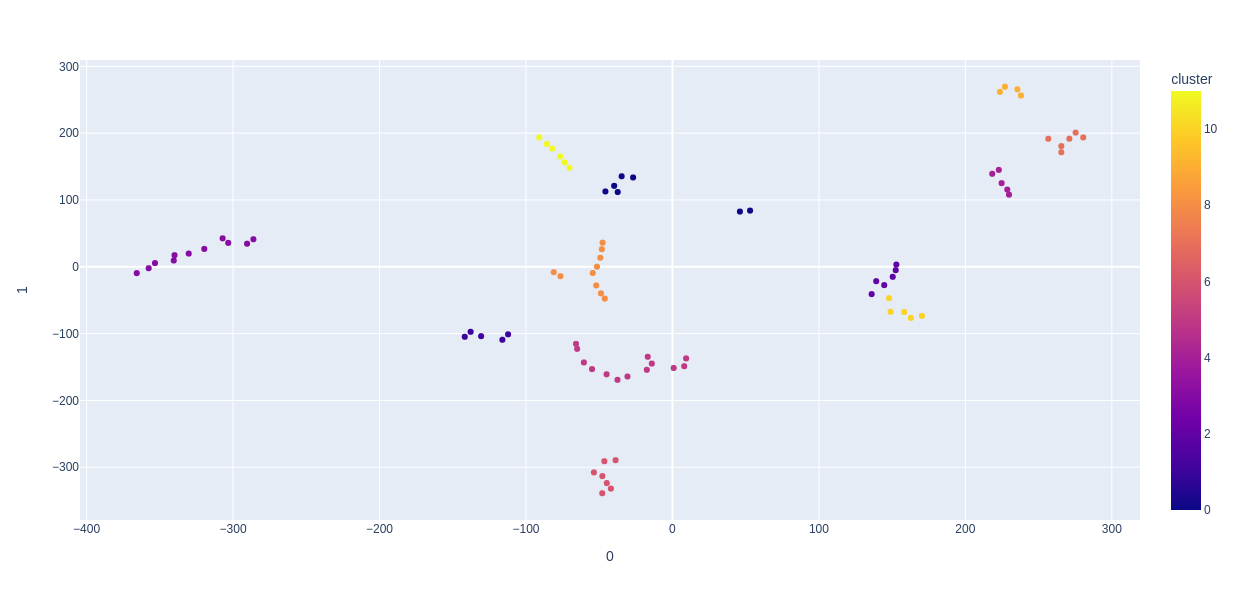

0       1  cluster
region                                               
Белгородская область          147.91  -46.99       10
Брянская область              -53.63 -307.68        6
Владимирская область         -112.23 -101.08        1
Воронежская область          -130.64 -103.81        1
Ивановская область            235.53  265.51        9
...                              ...     ...      ...
Амурская область              228.61  115.56        4
Магаданская область           224.76  125.17        4
Сахалинская область           -81.05   -8.07        8
Еврейская автономная область -303.30   35.78        3
Чукотский автономный округ   -365.76   -9.48        3

[85 rows x 3 columns]

In [184]:
em_model = GaussianMixture(n_components=12, max_iter = 1000)
em_model.fit(principal_components)
em_labels = em_model.predict(principal_components)

df_em_labled = pd.DataFrame(principal_components, index = df.index)
df_em_labled['cluster'] = em_labels

fig = px.scatter(df_em_labled, x = 0, y = 1, color='cluster', height = 600 , width=600)
fig.show()

df_em_labled

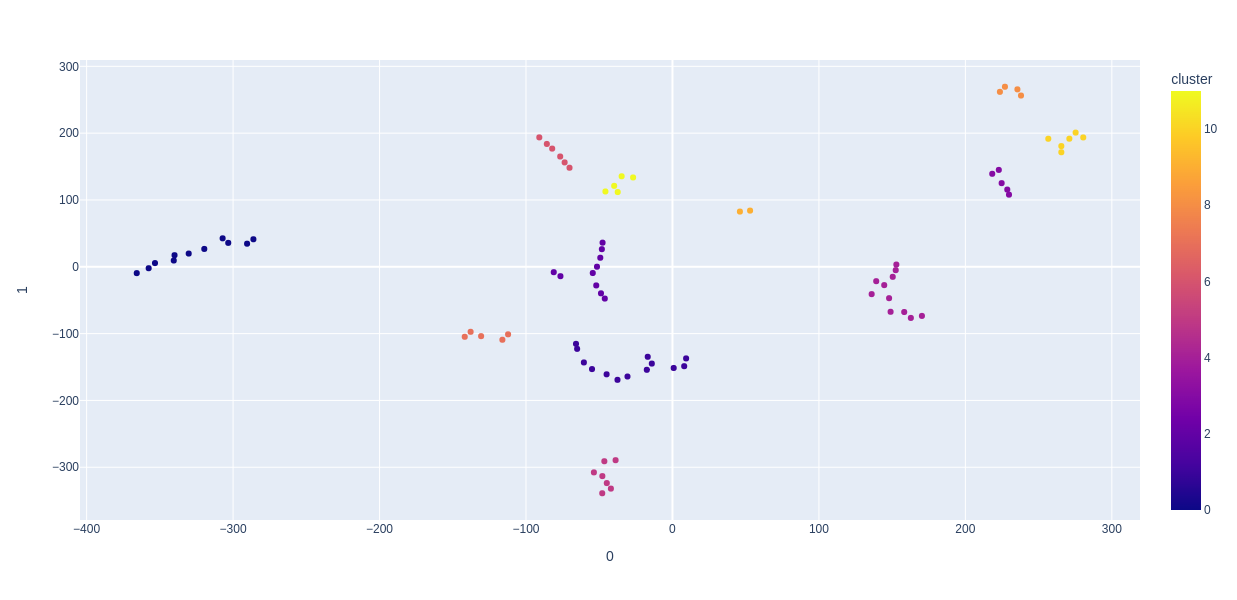

0       1  cluster
region                                               
Белгородская область          147.91  -46.99        4
Брянская область              -53.63 -307.68        5
Владимирская область         -112.23 -101.08        7
Воронежская область          -130.64 -103.81        7
Ивановская область            235.53  265.51        8
...                              ...     ...      ...
Амурская область              228.61  115.56        3
Магаданская область           224.76  125.17        3
Сахалинская область           -81.05   -8.07        2
Еврейская автономная область -303.30   35.78        0
Чукотский автономный округ   -365.76   -9.48        0

[85 rows x 3 columns]

In [185]:
ag_model = AgglomerativeClustering(n_clusters=12)
ag_model.fit(principal_components)
ag_labels = ag_model.labels_

df_ag_labled = pd.DataFrame(principal_components, index = df.index)
df_ag_labled['cluster'] = ag_labels

fig = px.scatter(df_ag_labled, x = 0, y = 1, color='cluster', height = 600 , width=600)
fig.show()

df_ag_labled

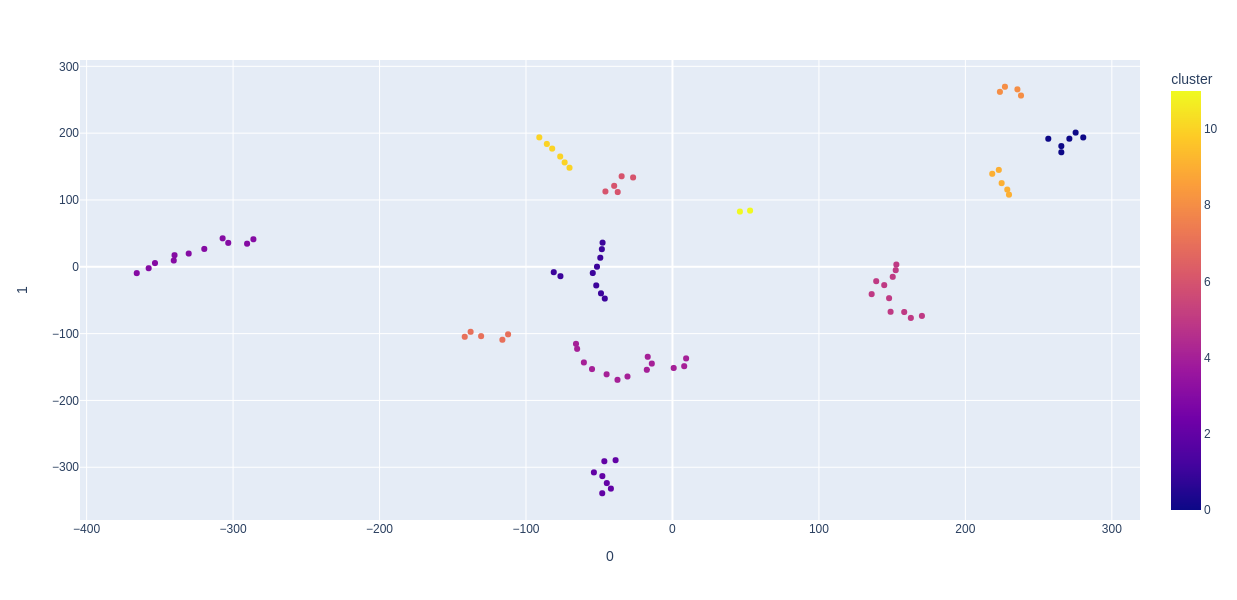

0       1  cluster
region                                               
Белгородская область          147.91  -46.99        5
Брянская область              -53.63 -307.68        2
Владимирская область         -112.23 -101.08        7
Воронежская область          -130.64 -103.81        7
Ивановская область            235.53  265.51        8
...                              ...     ...      ...
Амурская область              228.61  115.56        9
Магаданская область           224.76  125.17        9
Сахалинская область           -81.05   -8.07        1
Еврейская автономная область -303.30   35.78        3
Чукотский автономный округ   -365.76   -9.48        3

[85 rows x 3 columns]

In [186]:
km_model = KMeans(12)
km_model.fit(principal_components)
km_labels = km_model.labels_

df_km_labled = pd.DataFrame(principal_components, index = df.index)
df_km_labled['cluster'] = km_labels

fig = px.scatter(df_km_labled, x = 0, y = 1, color='cluster', height = 600 , width=600)
fig.show()

df_km_labled

Наилучший показатель метрики silhouette score показал алгоритм аглометративной кластеризации.В дальнейшем анализ кластеров будем производить на его основе его результатов.

In [187]:
mm_scaler = MinMaxScaler()

df_mm = mm_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_mm, index = df.index, columns=df.columns)
df_scaled

per_capita_cash_income  formal_wage_paid  \
region                                                                   
Белгородская область                            0.24              0.09   
Брянская область                                0.16              0.03   
Владимирская область                            0.13              0.07   
Воронежская область                             0.23              0.08   
Ивановская область                              0.14              0.01   
...                                              ...               ...   
Амурская область                                0.24              0.23   
Магаданская область                             0.69              0.80   
Сахалинская область                             0.60              0.70   
Еврейская автономная область                    0.14              0.18   
Чукотский автономный округ                      0.97              1.00   

                              ch_mort_urban  60_  grp  total_area_for_person  \
region                                                                         
Белгородская область                   0.10 0.19 0.08                   0.32   
Брянская область                       0.10 0.09 0.03                   0.60   
Владимирская область                   0.12 0.12 0.04                   0.28   
Воронежская область                    0.16 0.19 0.05                   0.53   
Ивановская область                     0.10 0.07 0.02                   0.33   
...                                     ...  ...  ...                    ...   
Амурская область                       0.11 0.05 0.06                   0.23   
Магаданская область                    0.02 0.00 0.19                   0.25   
Сахалинская область                    0.06 0.02 0.36                   0.19   
Еврейская автономная область           0.03 0.01 0.04                   0.07   
Чукотский автономный округ             0.01 0.00 0.30                   0.19   

                              living_area_for_person  living_room_count  \
region                                                                    
Белгородская область                            0.30               0.28   
Брянская область                                0.74               0.47   
Владимирская область                            0.18               0.16   
Воронежская область                             0.44               0.28   
Ивановская область                              0.32               0.22   
...                                              ...                ...   
Амурская область                                0.26               0.19   
Магаданская область                             0.01               0.06   
Сахалинская область                             0.25               0.12   
Еврейская автономная область                    0.01               0.16   
Чукотский автономный округ                      0.04               0.00   

                              new_born  population  ...  \
region                                              ...   
Белгородская область              0.10        0.12  ...   
Брянская область                  0.08        0.09  ...   
Владимирская область              0.09        0.11  ...   
Воронежская область               0.16        0.18  ...   
Ивановская область                0.06        0.08  ...   
...                                ...         ...  ...   
Амурская область                  0.06        0.06  ...   
Магаданская область               0.01        0.01  ...   
Сахалинская область               0.04        0.04  ...   
Еврейская автономная область      0.01        0.01  ...   
Чукотский автономный округ        0.00        0.00  ...   

                              industrial_production  retail_turnover  \
region                                                                 
Белгородская область                           0.10             0.48   
Брянская область                               0.03             0.

In [196]:
#df['em_cluster'] = em_labels
df['ag_cluster'] = ag_labels
df['km_cluster'] = km_labels
# df_scaled['em_cluster'] = em_labels
df_scaled['ag_cluster'] = ag_labels
# df_scaled['km_cluster'] = km_labels

In [189]:
grouped_data = df_scaled.groupby('ag_cluster').mean()

def plot_cluster_profile(grouped_data, n_clusters):
    """Визуализация профилей кластеров в виде полярной диаграммы.

    Args:
        grouped_data (_DataFrame_): сгруппированные по кластерам характеристики объектов
        n_clusters (_int_): количество кластеров
    """
    
    features = ['population', 'welfare_mean', 'per_capita_cash_income', 'manufacturing_industries', 'industrial_production', 'mining', 'retail_turnover', 'poverty_percent', 'new_born']
    
    fig = go.Figure()
    
    for i in range(n_clusters):
        fig.add_trace(go.Scatterpolar(
            r = grouped_data.loc[i, features].values,
            theta=features,
            fill='toself',
            name=f'Cluster {i}'
        ))
    fig.update_layout(
        showlegend=True,
        autosize=False,
        width=800,
        height=800
    )
    
    fig.show()

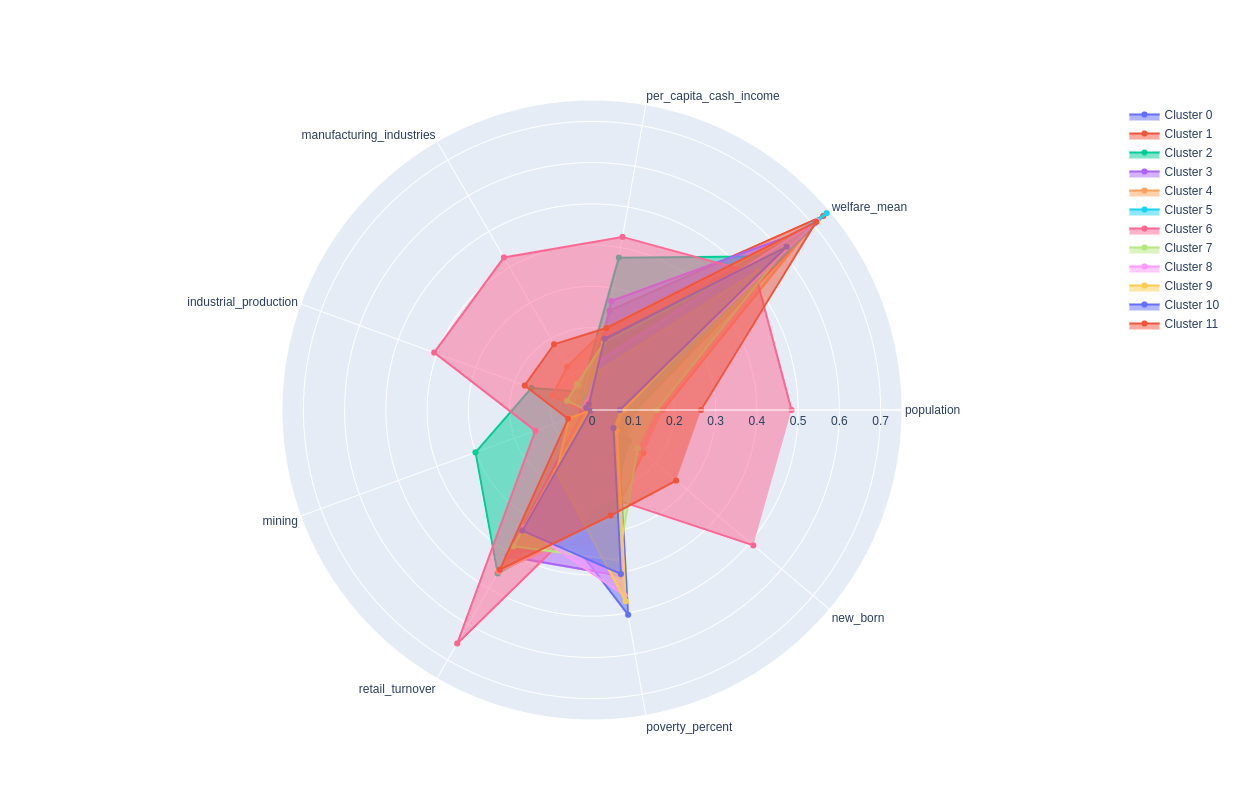

In [190]:
plot_cluster_profile(grouped_data, 12)

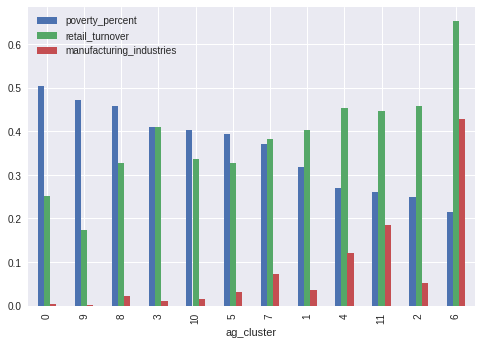

In [191]:
grouped_data.sort_values(by='poverty_percent', ascending=False)[['poverty_percent', 'retail_turnover', 'manufacturing_industries']].plot(kind='bar');

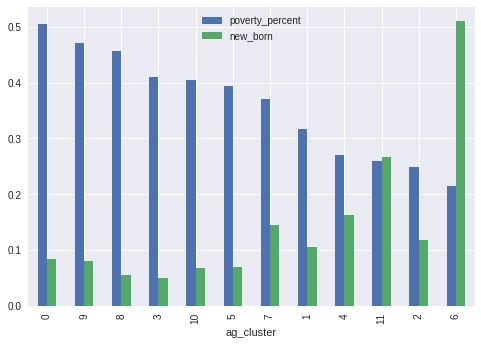

In [192]:
grouped_data.sort_values(by='poverty_percent', ascending=False)[['poverty_percent', 'new_born']].plot(kind='bar');

Результат анализа кластеров

* Кластер 0 и кластер 9. В них входят регионы, в которых наблядается наиболее острая потребность в помощи малообеспеченным слоям населения. Оба кластера характеризует крайне низкий уровень промышленного производства, обрабатывающей промышлинности, а так же низкий уровень потребления. 
* Кластер 3 и кластер 8. У регионов входящих в данные кластеры дела обстоят немного лучше, чем у регионов входящих в кластер 0 и 9. Тем не менее наблядается необходимость в помощи малообеспеченным слоям населения.  
* На диаграмме выше видим, что существует прямая связь между уровнем бености в регионе и уровнем потребления и производства. Чем выше уровень неблагополучия, тем ниже уровне потребления и производства. 